This is the overall code to:
    1) Take the broadband r image, convert to nanomaggies and AB mags
    2) Add in background
    3) Produce an error image according to Poisson statistics (+ background + readnoise)
    4) Produce an error spectrum according to the same statistics (at each wavelength)
    5) Prepare to entre into ppxf according to the MaNGA specs

In [46]:
import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits


from astropy.cosmology import WMAP9 as cosmo

import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches

import sys 

import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.ndimage import iterate_structure

sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np
import glob
from time import clock
from os import path

from ppxf import ppxf
import ppxf_util as util
plt.clf()

from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

import scipy.ndimage.filters as filters
from scipy import ndimage
from scipy.stats import norm

#os.chdir(os.path.expanduser('~/Documents/LAURA_SIMS'))

import photutils
import os



In [ ]:
'''Now I would really love to iterate for all possible viewing angles 0-6'''
img_list=['q0.5_fg0.3_allrx10/broadband_020.fits','q0.5_fg0.3_allrx10/broadband_040.fits',
         'q0.5_fg0.3_allrx10/broadband_070.fits','q0.5_fg0.3_allrx10/broadband_160.fits',
         'q0.5_fg0.3_allrx10/broadband_200.fits','q0.5_fg0.3_allrx10/broadband_210.fits',
         'q0.5_fg0.3_allrx10/broadband_230.fits']
myr=[20,40,70,160,200,210,230]
viewpts=[0,1,2,3,4,5,6]
plott='no'
os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/'))


sep=np.zeros((len(viewpts),len(myr)))
flux_r=np.zeros((len(viewpts),len(myr)))
myr_here=np.zeros((len(viewpts),len(myr)))

gini=np.zeros((len(viewpts),len(myr)))
m20=np.zeros((len(viewpts),len(myr)))
Assy=np.zeros((len(viewpts),len(myr)))
Clump=np.zeros((len(viewpts),len(myr)))
Con=np.zeros((len(viewpts),len(myr)))
plt_label=np.zeros((len(viewpts),len(myr)))
    
for k in range(len(viewpts)):
    viewpt=viewpts[k]
    
   
    

    
    for i in range(len(img_list)):#len(img_list)
        plt.clf()
        '''before any of this you have to choose the camera data'''
        a=produce_camera(myr[i],img_list[i],viewpt)#that last number is the viewpoing (camera 0)
        '''a output is actually surface brightness'''
        '''now you need to chop it down to the snapshot of SDSS imaging'''




        b=determine_coords(a[1][2], plott)#was c, taking the second dimension

        low_pass=b[4]
        num_sol=b[5]



        if num_sol==1:
            #this is if there's only really one solution because the bulges are too close together
            c=fit_2_gaussian(b[1],300-b[0],b[1],300-b[0],low_pass, plott)
        else:
            c=fit_2_gaussian(b[2],300-b[0],b[3],300-b[1],low_pass, plott)#was d[3],300-d[2],d[1],300-d[0]



        if c[4] > c[5]:
            '''this means point 1 is brighter'''
            in_x = c[1]
            in_y = c[0]
            in_2_x = c[3]
            in_2_y = c[2]

            reff_1=c[6]
            reff_2=c[7]

        if c[5] > c[4]:
            '''point 2 is the brighter source'''
            in_x = c[3]
            in_y = c[2]
            in_2_x = c[1]
            in_2_y = c[0]

            reff_1=c[7]
            reff_2=c[6]

        

        '''Now we need to clip this so that its the size of an SDSS image'''
        d=clip_image(a[1][2], a[0], 0.03, 300-in_x, in_y)

        '''d output is surface brightness in W/m/m^2/sr but cut'''
        #a[0] is pixelscale

        e=nanomags(0.03, a[0], d[0],viewpt, myr[i])#was a[1]
        texp=53.9
        prep=convolve_image(myr[i],e[0],e[1],e[2],0.03,a[0],viewpt, e[3], e[4], e[5], texp)
        '''Input to galfit needs to be nanomags'''

        length_gal=shape(d[0])[0]
        
        '''So you need to guess mag correctly mag = −2.5log10(ADUs/texp) + mag zpt.'''
        '''(mag zpt = 26.563)'''
        mag_zpt=26.563
        max_counts=np.max(np.array(prep[3]))
        mag_guess=-2.5*math.log10(max_counts/texp) + mag_zpt

        #abs(xcen2-xcen) < length_gal/2 and abs(ycen2-ycen)/2 < length_gal

        '''Find out how many bulges'''
        if abs(in_x-in_2_x) < length_gal/2 and abs(in_y-in_2_y) < length_gal/2 and in_y != in_2_y and in_x != in_2_x: 
            num_bulges=2
        else:
            num_bulges=1

        

        plt.clf()
        plt.imshow((prep[3]),norm=matplotlib.colors.LogNorm())
        plt.title('Feeding Galfit')
        plt.colorbar(label='Counts')
        #x_1-xcen+half_pixels
        plt.scatter(length_gal/2,length_gal/2, color='red')
        plt.scatter(length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x), color='red')
        plt.xlim([0,length_gal])
        plt.ylim([0,length_gal])
        plt.show()

        f=write_galfit_feedme(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2)#was 300-in_x






        
        g=run_galfit(viewpt,myr[i])
        
        output='GALFIT_folder/out_'+str(viewpt)+'_'+str(myr[i])+'.fits'
        out=pyfits.open(output)
        try:
            PA1=float(out[2].header['1_PA'][:7])
            PA2=PA1
            AR1=float(out[2].header['1_AR'][:7])
            h=galfit_params(viewpt,myr[i],num_bulges)

            

        except ValueError:
            f=write_galfit_feedme_prev(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2,viewpt,myr[i-1])#was 300-in_x
            '''Run based upon the last feedme file'''
            g=run_galfit(viewpt,myr[i])
            h=galfit_params(viewpt,myr[i],num_bulges)
            


        
            
        sep[k,i]=(h[0])
        flux_r[k,i]=(h[1])
        myr_here[k,i]=(myr[i])



        PA1=h[2]
        PA2=h[3]
        posx_1=h[4]
        posy_1=h[5]
        posx_2=h[6]
        posy_2=h[7]
        AR_1=h[8]
        gal_out=h[9]


        ii=calculate_petrosian_radius(d[0], PA1, AR_1, a[0])

        '''Now we need to apply the segmentation mask to the normal surface brightness'''
        mask_sb=ma.masked_where(ii[0] ==0, d[0])



        j=gini_m20(myr[i],np.flipud(mask_sb),viewpt, d[1])#was result_nano

        gini[k,i]=(j[0])
        m20[k,i]=(j[1])
        plt_label[k,i]=(str(myr[i]))





        '''What if I want to actually do the diagnostic from someone where you get to flip an image around?'''


        mask_result=ma.masked_where(ii[0]==0, np.flipud(prep[0]))
        mask_result_bg=ma.masked_where(ii[0]==0, np.flipud(prep[1]))

        gg=img_assy(np.flipud(prep[0]), np.flipud(prep[1]), in_x, in_y, viewpt, myr[i], plott, ii[4])




        kk=measure_concentration(ii[4], np.flipud(prep[0]))
        #input: petrosian radius






        l = clumpiness(np.flipud(prep[0]), np.flipud(prep[1]), ii[4])



        Assy[k,i]=(gg[0])
        Clump[k,i]=(l[0])
        Con[k,i]=(kk[0])



    




/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:

Con=Con.flatten()
Assy=Assy.flatten()
Clump=Clump.flatten()
print(shape(Con))
color=[]
for i in range(len(Con)):
    if Con[i] < 3 and abs(Assy[i]) > 0.35 and Clump[i] > 0.4:
        color.append('Pink')
    else:
        color.append('Black')

plt.scatter(Con, (Assy), color=color)
plt.ylabel('A(R)')
plt.xlabel('C(R)')
plt.ylim([1,-0.2])
plt.xlim([5.2,1.8])
plt.axhline(y=0.35)
plt.annotate("", xy=(5, 0.45), xytext=(5, 0.37),
    arrowprops=dict(arrowstyle="->"))
plt.show()

plt.scatter(Clump, Assy, color=color)
plt.ylabel('A(R)')
plt.xlabel('S(R)')
plt.axhline(y=0.35)
plt.axvline(x=0.4)
plt.ylim([1,-0.2])
plt.xlim([-0.2,1])
plt.annotate("", xy=(-0.16, 0.45), xytext=(-0.16, 0.37),
    arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(0.35, 0.9), xytext=(0.4, 0.9),
    arrowprops=dict(arrowstyle="->"))
plt.show()

plt.scatter(Con,Clump, color=color)
plt.ylabel('S(R)')
plt.xlabel('C(R)')
plt.axhline(y=0.4)
plt.ylim([1,-0.2])
plt.xlim([5.2,1.8])
plt.annotate("", xy=(5, 0.49), xytext=(5, 0.42),
    arrowprops=dict(arrowstyle="->"))
plt.show()



In [104]:
file_path='GALFIT_folder/galfit.feedme_0_200'

file_path_new=''
    
f = open(file_path, 'r+')
data=f.readlines()

for line in data:
    words = line.split()

    
    if words[0]=='B)':
        print(words)
        print(words[1])
        f.write('Fuck')



    
'''data = f.readlines()


    for line in data:
        words = line.split()
        
        #print(words[0])
        if words[0]=='B)':
            print(words)
            print(words[1])
            file_path.write('Fuck')'''
'''now you need to replace this'''
        
file_path.close()      
stop

['===============================================================================']
['#', 'IMAGE', 'and', 'GALFIT', 'CONTROL', 'PARAMETERS']
['A)', 'out_convolved_0_200.fits', '#', 'Input', 'data', 'image', '(FITS', 'file)']
['B)', 'out_0_200.fits', '#', 'Output', 'data', 'image', 'block']
['B)', 'out_0_200.fits', '#', 'Output', 'data', 'image', 'block']
out_0_200.fits
['C)', 'out_sigma_convolved_0_200.fits', '#', 'Sigma', 'image', 'name', '(made', 'from', 'data', 'i$']
['D)', 'none', '#', '#', 'Input', 'PSF', 'image', 'and', '(optional)', 'diffusion', 'kernel']
['E)', 'none', '#', 'PSF', 'fine', 'sampling', 'factor', 'relative', 'to', 'data']
['F)', 'none', '#', 'Bad', 'pixel', 'mask', '(FITS', 'image', 'or', 'ASCII', 'coord', 'list)']
['G)', 'none', '#', 'File', 'with', 'parameter', 'constraints', '(ASCII', 'file)']
['H)', '1', '182', '1', '182', '#', 'Image', 'region', 'to', 'fit', '(xmin', 'xmax', 'ymin', 'ymax)']
['I)', '182', '182', '#', 'Size', 'of', 'the', 'convolution', 'box',

AttributeError: 'str' object has no attribute 'close'

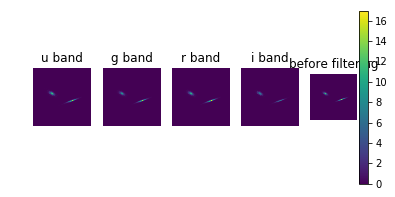

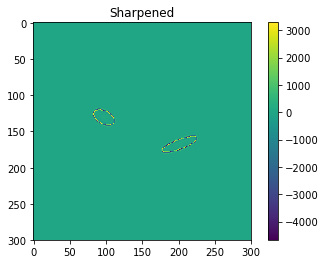

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


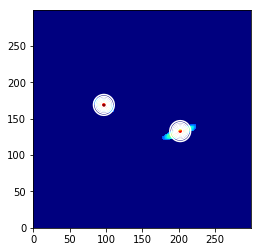

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


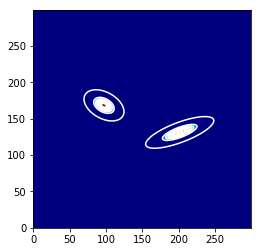

reff 8.78850700383 13.1117802994 is this in pixels?


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


length 60
num of bulges 1


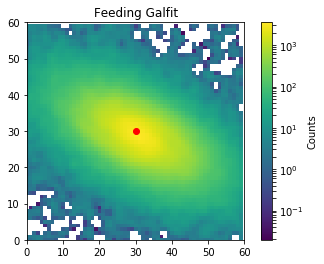

mag_guess 22.010985014692306


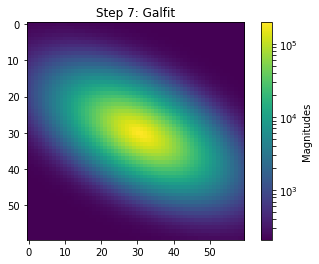

Sersic indices 0.7443 +/- 0.0028
Effective Radius in pixels 10.2767 +/- 0.0161
magnitudes 7.6662 +/- 0.0015
PAs -61.6442 +/- 0.0784
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 5.442658


/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


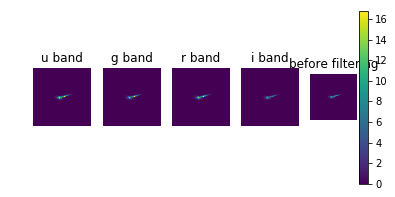

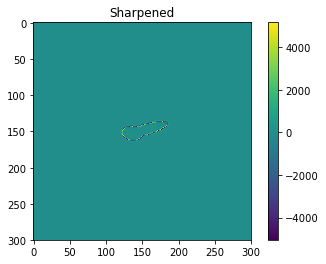

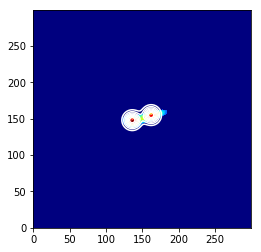

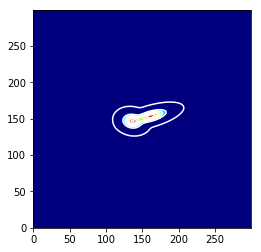

reff 8.37919477948 12.3227242108 is this in pixels?
length 60
num of bulges 2


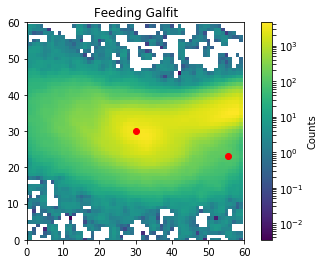

mag_guess 21.762366279402126


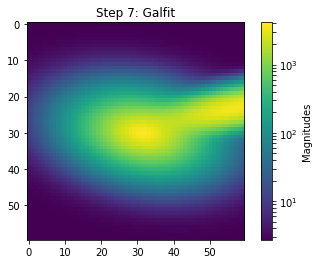

Sersic indices 0.7285 +/- 0.0050 0.5000 +/- 0.0048
Effective Radius in pixels 9.4717 +/- 0.0373 14.0095 +/- 0.3055
pos 1 32.3127 +/- 0.0305 31.2048 +/- 0.0183
pos 2 58.3969 +/- 0.2502 24.1398 +/- 0.0464
magnitudes 11.9509 +/- 0.0046 11.8963 +/- 0.0264
flux ratio 0.9509550739246811
PAs -78.8690 +/- 0.2630 79.3353 +/- 0.1499
sep in pix 27.0240580713
sep in kpc 4.50399166251
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 32.96753


Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division


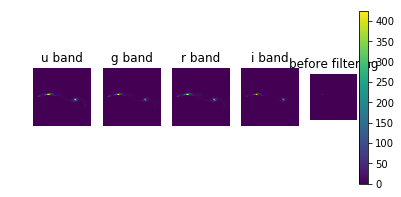

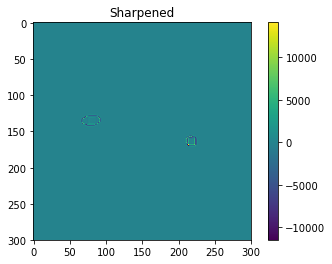

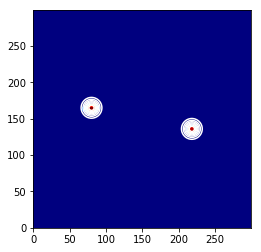

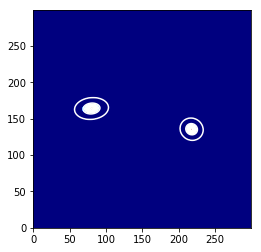

reff 5.30719022643 6.70996595507 is this in pixels?
length 60
num of bulges 1


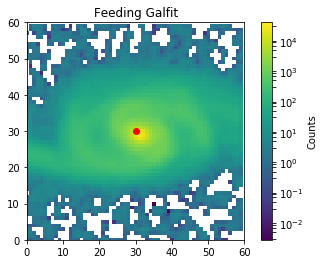

mag_guess 19.37345273484782


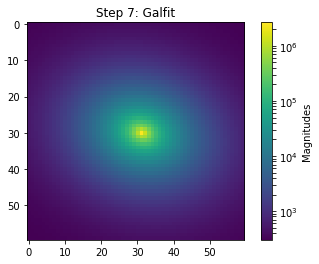

Sersic indices 2.4506 +/- 0.0244
Effective Radius in pixels 3.7422 +/- 0.0347
magnitudes 7.7440 +/- 0.0043
PAs -74.0143 +/- 1.0529
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 81.98262


Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division


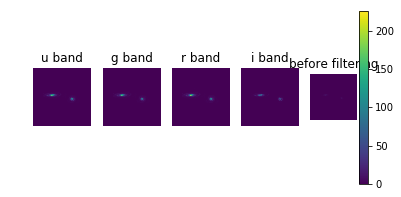

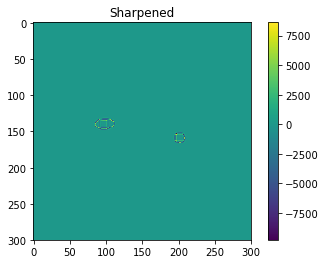

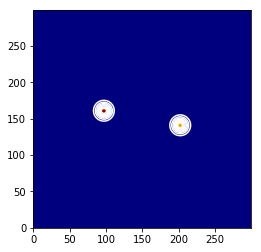

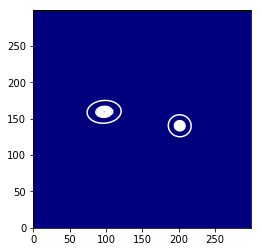

reff 6.74044046844 5.26483575294 is this in pixels?
length 60
num of bulges 1


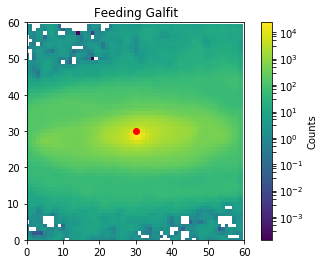

mag_guess 19.94807346844414


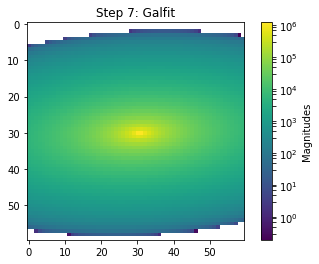

Sersic indices 2.3650 +/- 0.0208
Effective Radius in pixels 11.0297 +/- 0.1094
magnitudes 7.2208 +/- 0.0068
PAs 87.2100 +/- 0.1804
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 61.22263


Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division


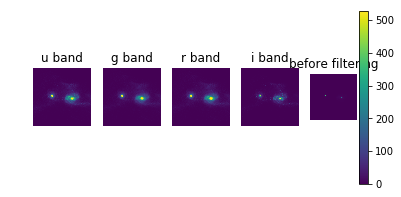

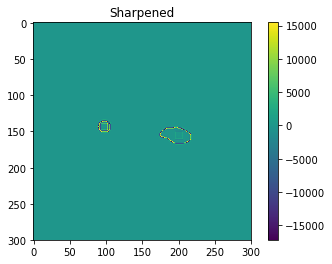

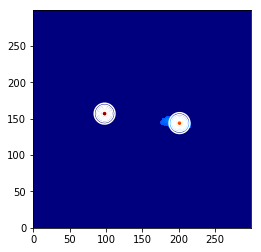

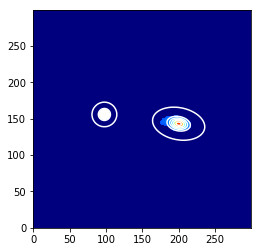

reff 5.6672164127 10.3038767407 is this in pixels?
length 182
num of bulges 1


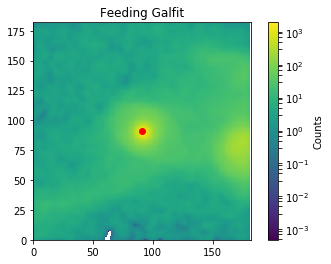

mag_guess 22.660055049708138


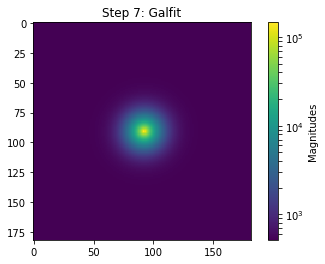

Sersic indices 1.3297 +/- 0.0118
Effective Radius in pixels 6.7824 +/- 0.0492
magnitudes 8.8572 +/- 0.0039
PAs 67.5702 +/- 10.6166
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2

Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division


 12.51846


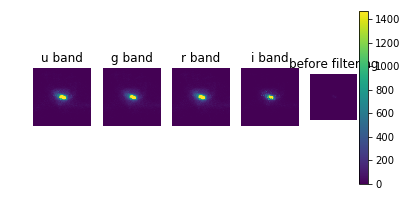

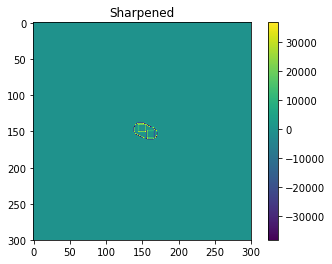

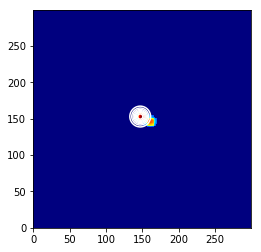

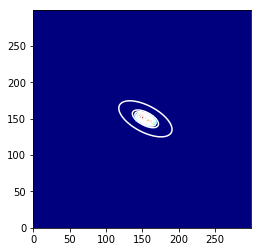

reff 10.8940454527 10.8944222202 is this in pixels?
length 182
num of bulges 2


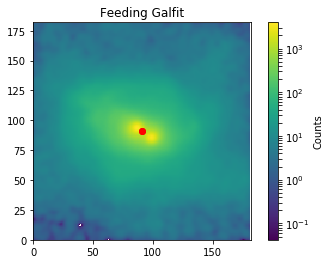

mag_guess 21.892943259904683


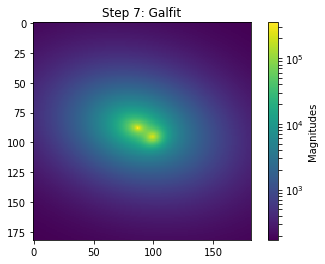

Sersic indices 2.2805 +/- 0.0057 0.9401 +/- 0.0054
Effective Radius in pixels 21.9548 +/- 0.0768 5.4918 +/- 0.0234
pos 1 88.0073 +/- 0.0078 88.8056 +/- 0.0064
pos 2 100.2056 +/- 0.0114 96.1969 +/- 0.0072
magnitudes 7.0747 +/- 0.0027 8.7383 +/- 0.0033
flux ratio 4.628497143090867
PAs -76.0521 +/- 0.1685 84.5925 +/- 0.6937
sep in pix 14.2623701039
sep in kpc 2.37705217573
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 4.771333


Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division


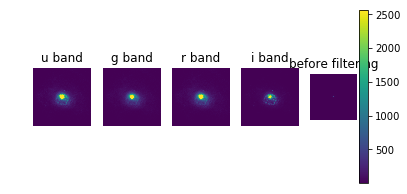

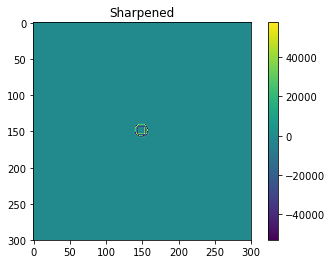

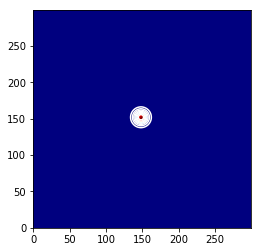

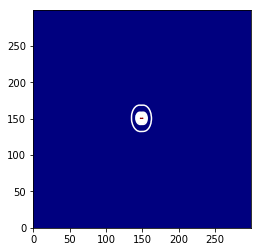

reff 4.83382730563 4.75847865647 is this in pixels?
length 182
num of bulges 2


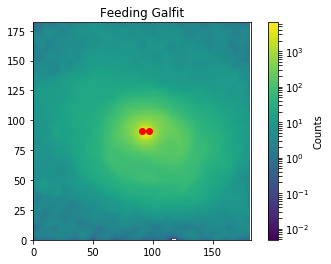

mag_guess 21.356812690820277


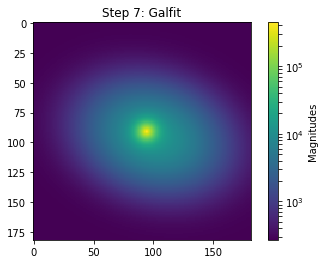

Sersic indices 0.5911 +/- 0.0030 1.0490 +/- 0.0029
Effective Radius in pixels 33.4908 +/- 0.0783 5.4428 +/- 0.0121
pos 1 100.8503 +/- 0.0501 95.6697 +/- 0.0377
pos 2 95.3055 +/- 0.0047 91.8459 +/- 0.0045
magnitudes 7.4769 +/- 0.0028 7.8626 +/- 0.0019
flux ratio 1.4265270131383574
PAs -73.6126 +/- 0.2368 83.7443 +/- 1.3430
sep in pix 6.73520056791
sep in kpc 1.12252893785
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 3.29932


Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division


In [21]:
img_list=['q0.5_fg0.3_allrx10/broadband_020.fits','q0.5_fg0.3_allrx10/broadband_040.fits',
         'q0.5_fg0.3_allrx10/broadband_070.fits','q0.5_fg0.3_allrx10/broadband_160.fits',
         'q0.5_fg0.3_allrx10/broadband_200.fits','q0.5_fg0.3_allrx10/broadband_210.fits',
         'q0.5_fg0.3_allrx10/broadband_230.fits']
myr=[20,40,70,160,200,210,230]
#myr=[200]
sep=[]
flux_r=[]
myr_here=[]
image=[]
gini=[]
m20=[]
Assy=[]
Clump=[]
Con=[]
plt_label=[]
viewpt=1

plott='yes'
os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/'))
for i in range(len(img_list)):#len(img_list)
    plt.clf()
    '''before any of this you have to choose the camera data'''
    a=produce_camera(myr[i],img_list[i],viewpt)#that last number is the viewpoing (camera 0)
    '''a output is actually surface brightness'''
    '''now you need to chop it down to the snapshot of SDSS imaging'''
    
    
    
    
    b=determine_coords(a[1][2], plott)#was c, taking the second dimension
    
    low_pass=b[4]
    num_sol=b[5]
    
    
    
    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        c=fit_2_gaussian(b[1],300-b[0],b[1],300-b[0],low_pass, plott)
    else:
        c=fit_2_gaussian(b[2],300-b[0],b[3],300-b[1],low_pass, plott)#was d[3],300-d[2],d[1],300-d[0]

    
    
    if c[4] > c[5]:
        '''this means point 1 is brighter'''
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]
        
        reff_1=c[6]
        reff_2=c[7]
        
    if c[5] > c[4]:
        '''point 2 is the brighter source'''
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]
        
        reff_1=c[7]
        reff_2=c[6]
        
    print('reff', reff_1, reff_2, 'is this in pixels?')
    
        
    
    '''Now we need to clip this so that its the size of an SDSS image'''
    d=clip_image(a[1][2], a[0], 0.03, 300-in_x, in_y)
    
    '''d output is surface brightness in W/m/m^2/sr but cut'''
    #a[0] is pixelscale
    
    e=nanomags(0.03, a[0], d[0],viewpt, myr[i])#was a[1]
    texp=53.9
    prep=convolve_image(myr[i],e[0],e[1],e[2],0.03,a[0],viewpt, e[3], e[4], e[5], texp)
    '''Input to galfit needs to be nanomags'''
    
    length_gal=shape(d[0])[0]
    print('length', length_gal)
    '''So you need to guess mag correctly mag = −2.5log10(ADUs/texp) + mag zpt.'''
    '''(mag zpt = 26.563)'''
    mag_zpt=26.563
    max_counts=np.max(np.array(prep[3]))
    mag_guess=-2.5*math.log10(max_counts/texp) + mag_zpt
    
    #abs(xcen2-xcen) < length_gal/2 and abs(ycen2-ycen)/2 < length_gal
    
    '''Find out how many bulges'''
    if abs(in_x-in_2_x) < length_gal/2 and abs(in_y-in_2_y) < length_gal/2 and in_y != in_2_y and in_x != in_2_x: 
        num_bulges=2
    else:
        num_bulges=1
        
    print('num of bulges', num_bulges)
    
    
    plt.clf()
    plt.imshow((prep[3]),norm=matplotlib.colors.LogNorm())
    plt.title('Feeding Galfit')
    plt.colorbar(label='Counts')
    #x_1-xcen+half_pixels
    plt.scatter(length_gal/2,length_gal/2, color='red')
    plt.scatter(length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x), color='red')
    plt.xlim([0,length_gal])
    plt.ylim([0,length_gal])
    plt.show()

    f=write_galfit_feedme(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2)#was 300-in_x
    

    
    
    
    
    #write_galfit_feedme(view,number,xcen,ycen,xcen2,xcen1, mag, mag_zpt, length_gal):
    print('mag_guess', mag_guess)
    
    
    g=run_galfit(viewpt,myr[i])
    
    
    h=galfit_params(viewpt,myr[i],num_bulges)
    
    
    
    
    sep.append(h[0])
    flux_r.append(h[1])
    myr_here.append(myr[i])
    
    
    
    PA1=h[2]
    PA2=h[3]
    posx_1=h[4]
    posy_1=h[5]
    posx_2=h[6]
    posy_2=h[7]
    AR_1=h[8]
    gal_out=h[9]
  
    
    ii=calculate_petrosian_radius(d[0], PA1, AR_1, a[0])
    
    '''Now we need to apply the segmentation mask to the normal surface brightness'''
    mask_sb=ma.masked_where(ii[0] ==0, d[0])
    
    
   
    j=gini_m20(myr[i],np.flipud(mask_sb),viewpt, d[1])#was result_nano
    
    gini.append(j[0])
    m20.append(j[1])
    plt_label.append(str(myr[i]))
    
    
  
    
    
    '''What if I want to actually do the diagnostic from someone where you get to flip an image around?'''
    
    
    mask_result=ma.masked_where(ii[0]==0, np.flipud(prep[0]))
    mask_result_bg=ma.masked_where(ii[0]==0, np.flipud(prep[1]))
    
    gg=img_assy(np.flipud(prep[0]), np.flipud(prep[1]), in_x, in_y, viewpt, myr[i], plott, ii[4])
    
    
    
    
    k=measure_concentration(ii[4], np.flipud(prep[0]))
    #input: petrosian radius
    
    
    
    
    
    
    l = clumpiness(np.flipud(prep[0]), np.flipud(prep[1]), ii[4])
    
    
    
    Assy.append(gg[0])
    Clump.append(l[0])
    Con.append(k[0])
    
    
    
    



In [94]:
print(Clump)
print(Assy)

[-0.74437647541067598, -0.58607314230419116, -0.29015632262094476, -0.69897110926473105, -0.49957410710096783, -0.49695638311359208, -0.51169446169623678]
[-1.1130517090978169, -0.429313429904429, -0.56343892032071274, -0.80792682288223217, -0.71617313162003338, -0.93517156656754086, -0.55969026223001295]


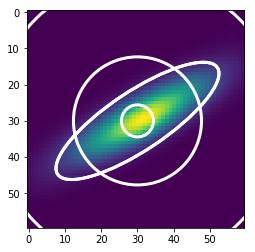

In [190]:
from matplotlib.animation import FuncAnimation
FFwriter = matplotlib.animation.FFMpegWriter(fps=0.5, extra_args=['-vcodec', 'libx264'])


fig, ax = plt.subplots()

ax.imshow(np.flipud(ii[1]))
ii[3].plot(lw=3, color='white')
gg[2].plot(lw=3, color='white')
k[1].plot(lw=3, color='white')
k[2].plot(lw=3, color='white')



plt.show()


plt.clf()
fig, ax = plt.subplots()
fig.set_tight_layout(True)
#div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')

pics=[a[1][2],low_pass,low_pass,d[0],e[0], np.flipud(e[1]), np.flipud(prep[0]), gal_out, ii[1], 
      mask_result, mask_result,gg[1], np.flipud(prep[0]), l[1]]
lim=[[0,300],[0,300],[0,300],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60]]
title=['Snapshot','Low Pass Filter','Identify the Center',
       r'Clipped to SDSS size (50$^{\prime\prime}$ x 50$^{\prime\prime}$)',
       'Convert from Surface Brightness to Nanomaggies', 'Introduce a Sky Background',
       'Convolve with Seeing', 'Model with Galfit','Measure Petrosian Radius',
       'Apply Segmentation Map to Identify Galaxy Pixels', r'Calculate G and M$_{20}$',
        'Calculate Asymmetry', 'Calculate Concentration', 'Calculate Clumpiness']
words=['','','','','','','','','','',r'G = '+str(round(j[0],1))+r', M$_{20}$ = '+str(round(j[1],1)),r'A = '+str(round(gg[0],1)),
      r'C = '+str(round(k[0],1)), r'S = '+str(round(l[0],1))]




#stop

im = ax.imshow(pics[0])
cb = fig.colorbar(im, ax=ax)
tx = ax.set_title('Frame 0')

#
ann_list = []
line_list = []
    
def update(j):
    for i, a in enumerate(ann_list):
        a.remove()
    '''if len(line_list) !=0:
        print(line_list)
        for i, a in enumerate(line_list):
            '''
    #line_list.remove()
  
            
    ann_list[:] = []
    line_list[:] = []
    #circle = Circle([2 * cos(i * np.pi / 5.), 2 * sin(i * np.pi / 5.)],
    #    radius=0.25, color='green', fill=True)
    #ax.add_patch(circle)
    '''ax.set_xlim(lim[i])
    ax.set_ylim(lim[i])
    ax.set_title(title[i])
    fig.colorbar(im,ax=ax)'''
    #cbar = plt.colorbar(im)
    #print('lim', lim[i])
    #cbar=plt.colorbar(im)
    #artists.append([im])
    
    arr = pics[j]
    
    
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    im.set_cmap('jet')
    if j==2:
        lines=ax.scatter(in_y,300-in_x, color='white', s=10)
        line_list.append(lines)
    '''if j==8:'''
    if j==8:
        lines=ii[3].plot(lw=3, color='white')
        line_list.append(lines)
    if j==11:
        lines=gg[2].plot(lw=3, color='white')
        line_list.append(lines)
    if j==12:
        lines=k[1].plot(lw=3, color='white')
        line_list.append(lines)
        lines=k[2].plot(lw=3, color='white')
        line_list.append(lines)
    
    
    ax.set_title('Step {0}: '.format(j+1)+title[j])
    if j ==11 or j==12 or j==13:
        ann =ax.annotate(str(words[j]), xy=(0.05,0.9), xycoords='axes fraction', color='white')
    else:
        ann =ax.annotate(str(words[j]), xy=(0.05,0.9), xycoords='axes fraction')
    
    ann_list.append(ann)
    
    
    
   
    return annotation, ax,  im#, cbar



if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, len(pics)))
    
    #anim.save('animation/test.gif', dpi=80, writer='imagemagick')
    
    anim.save('animation/view2.mp4', writer=FFwriter,dpi=180)

#anim = animation.ArtistAnimation(fig, artists, interval=500, repeat_delay=1500)
#anim.save('animation/dynamic_images.mp4', writer=FFwriter)

In [49]:
E_S0_gini=[0.62,0.62,0.63,0.62,0.6,0.63,0.6, 
          0.61,0.6,0.56,0.57,0.57,0.58,0.6,0.58,0.56,0.65,0.6,0.63]
E_S0_M20=[-2.45,-2.58,-2.54,-2.58,-2.56,-2.66,-2.60,
         -2.36,02.48,-2.33,-2.40,-2.5,-2.52,-2.37,-2.22,-2.57,-2.69,-2.69,-2.86]

Sa_Sbc_gini=[0.57,0.59,0.61,0.59,0.55,0.55,0.62,0.6,0.48,0.53,0.56,0.52,0.53,0.55]
Sa_Sbc_M20=[-2.2,-2.32,-2.52,-2.6,-2.19,-1.97,-1.27,-2.24,-1.73,-2.09,
           -2.06,-1.53,-1.84,-1.69]

Sc_gini=[0.5,0.44,0.5,0.48,0.47,0.51,0.52,0.58,0.52,0.49,0.53,0.55,0.55,
        0.47,0.42,0.47,0.52,0.58,0.57,0.47,0.5]
Sc_M20=[-1.63,-1.38,-1.41,-1.58,-1,-1.32,-1.64,-2.1,-1.76,-1.43,-1.46,-1.86,
       -1.64,-1.52,-1.34,-1.5,-1.84,-1.61,-1.75,-1.45,-1.82]


dashed_line_x=np.linspace(-0.5,-3,100)
dashed_line_y=[-0.115*x + 0.384 for x in dashed_line_x]

plt.clf()
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(dashed_line_x, dashed_line_y, ls='--', color='black')

for i in range(len(gini)):
    ax1.scatter(m20[i], gini[i], label=plt_label[i], marker='*', s=55)
ax1.scatter(E_S0_M20, E_S0_gini, label='E/S0 Lotz et al. 2004',edgecolor='red', s=15)
ax1.scatter(Sa_Sbc_M20, Sa_Sbc_gini, label='Sa-Sbc Lotz et al. 2004',marker='^',edgecolor='green', s=15)
ax1.scatter(Sc_M20, Sc_gini, label='Sc-Sd Lotz et al. 2004',marker='x',color='blue', s=15)


ax1.set_xlim([0,-3])
ax1.set_ylim([0.3,0.8])
ax1.set_xlabel(r'M$_{20}$')
ax1.set_ylabel(r'G')
ax1.set_aspect(abs(3)/abs(max(gini)-0.3))
#plt.axis('equal')
#ax1.legend(bbox_to_anchor=(1.025, 1.025))
ax1.legend(loc='lower left',
          ncol=3)
#ax1.set_aspect('equal')
plt.tight_layout()
savefig('../MaNGA_Papers/Paper_I/gini_m20_empty.pdf')

In [3]:
flux_r_r=[]#reduced
for i in range(len(flux_r)):
    if flux_r[i] > 1:
        flux_r_r.append( 1/flux_r[i])
    else:
        flux_r_r.append(flux_r[i])
        
print(len(flux_r), len(flux_r_r))

plt.clf()

fig, ax1 = plt.subplots()

ax1.scatter(myr,sep)
ax1.set_xlabel('Time [Myr]', size=20)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Separation [kpc]', color='b', size=20)


ax2 = ax1.twinx()

ax2.scatter(myr, flux_r_r, color='r')
ax2.set_ylabel('Flux Ratio', size=20, color='r')
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/time_5.pdf')



0 0


ValueError: x and y must be the same size

In [467]:
plt.clf()

fig=plt.figure()
for i in range(7):
    ax='ax'+str(i)
    ax=fig.add_subplot(2,4,i+1)
    img=image[i]
    index=np.where(img<0)
    img[index] = 0.1
    
    
    im=ax.imshow(img, vmin=0.1, vmax=10,norm=matplotlib.colors.LogNorm())
    
    ax.set_title(str(myr[i])+' Myr')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if i==4:
        plt.colorbar(im,orientation='horizontal', label='NMgy')
    else:
        cbar=plt.colorbar(im,orientation='horizontal')
        cbar.ax.set_xticklabels([]) 

savefig('../MaNGA_papers/Paper_I/time_pics_5.pdf')

In [2]:
def fit_gaussian(x_1,y_1, data):
# Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, 299, 300)
    y = np.linspace(0, 299, 300)
    x, y = np.meshgrid(x, y)
    

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (20,x_1,y_1,7,7,0,10)
    data=data.ravel()
    
    print(shape(data))
    
    #And plot the results:
    
    data_here = twoD_Gaussian((x,y), *initial_guess)
    
    fig, ax = plt.subplots(1, 1)
    ax.hold(True)
    ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
        extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_here.reshape(300, 300), 8, colors='w')
    plt.show()

    popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)
    data_fitted = twoD_Gaussian((x, y), *popt)
    


    fig, ax = plt.subplots(1, 1)
    ax.hold(True)
    ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
        extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_fitted.reshape(300, 300), 8, colors='w')
    plt.show()
    
    return popt[1], popt[2]


In [3]:
def fit_2_gaussian(x_1,y_1,x_2,y_2, data, plot):
# Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, 299, 300)
    y = np.linspace(0, 299, 300)
    x, y = np.meshgrid(x, y)
    

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (20,x_1,y_1,7,7,0,10,20,x_2,y_2,7,7,0)
    data=data.ravel()
    
   
    
    #And plot the results:
    
    data_here = twoD_two_Gaussian((x,y), *initial_guess)
    if plot=='yes':
        fig, ax = plt.subplots(1, 1)
        ax.hold(True)
        ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
            extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_here.reshape(300, 300), 8, colors='w')
        plt.show()

    popt, pcov = opt.curve_fit(twoD_two_Gaussian, (x, y), data, p0=initial_guess)
    data_fitted = twoD_two_Gaussian((x, y), *popt)
    
 
    if plot=='yes':
        fig, ax = plt.subplots(1, 1)
        ax.hold(True)
        ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
            extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_fitted.reshape(300, 300), 8, colors='w')
        plt.show()
    
    return popt[1], popt[2], popt[8], popt[9], popt[0], popt[7], np.sqrt(popt[3]**2+popt[4]**2), np.sqrt(popt[10]**2+popt[11]**2)


In [4]:
'''This code block reads in the broadband images and then will open the broadband extension,
...
'''
def produce_camera(myr,img, viewpoint):
    im=pyfits.open(img)

    plt.clf()

    camera_data = im['CAMERA'+str(viewpoint)+'-BROADBAND'].data
    #print('header', a['CAMERA'+str(viewpoint)+'-BROADBAND'].header)
    pixelscale =  im['CAMERA'+str(viewpoint)+'-BROADBAND'].header['CD1_1']

    

    xs = np.linspace(0,shape(camera_data[0])[0]-1,shape(camera_data[0])[0])
    xs_kpc = [pixelscale*x for x in xs]

    '''First make a plot of all the different filters side by side'''
    fig=plt.figure()
    ax0=fig.add_subplot(1,5,1)
    ax0.imshow(camera_data[0], vmin=0, vmax=15)
    ax0.set_title('u band')
    plt.axis('off')

    ax1=fig.add_subplot(1,5,2)
    ax1.imshow(camera_data[1], vmin=0, vmax=15)
    ax1.set_title('g band')
    plt.axis('off')

    ax2=fig.add_subplot(1,5,3)
    ax2.imshow(camera_data[2], vmin=0, vmax=15)
    ax2.set_title('r band')
    plt.axis('off')

    ax3=fig.add_subplot(1,5,4)
    im3=ax3.imshow(camera_data[3], vmin=0, vmax=15)
    ax3.set_title('i band')
    #plt.colorbar(im3, orientation='horizontal')
    plt.axis('off')

    ax4=fig.add_subplot(1,5,5)
    ax4.imshow(camera_data[4], vmin=0, vmax=15)
    ax4.set_title('z band')
    plt.axis('off')
    savefig('../MaNGA_papers/Paper_I/all_filters_'+str(viewpoint)+'_'+str(myr)+'.pdf')
    return pixelscale, camera_data




In [5]:
'''Now I have to convert the units of LAURAS sims into nanomaggies and AB mags (mags of DR7 and DR13)
'''
def nanomags(z, pixscale, camera_data, view, number):
#first, go from specific intensity (because we have per steradian) to 
#janskies (W/Hz/m^2)
    c = 299792.458*1000#to get into m/s

#this 1.35e-6 comes from the arcsin(R_sky/Distance to object)
#the answer needs to be in radians

#J=10^-26 W/m^2/Hz, so units of flux density
#reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html
#We need to go from a spectral brightness (I_nu) which is in m units
#To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)

#So you need to multiply the Fν by c / λ^2 to convert it into Fλ. 
#But we are not done yet! Recalling from above, the units of Fλ 
#are not an energy density. You need to get another factor of λ 
#in there to make the units work out to be energy density: 
#calculate λFλ to get units of ergs/s/cm^2.

#1.35e-6 comes from: sin^-1(pixelscale=0.166666#kpc/pix/ comoving distance in kpc)
    pixelscale=pixscale#0.166666#kpc/pix/
    d_a = cosmo.angular_diameter_distance(z).value#, **fidcosmo)
    d_co = cosmo.comoving_distance(z).value
    d_lum = cosmo.luminosity_distance(z).value 
    #print("Angluar-diameter distance to z=0.03 is", 1000*(d_a), 'kpc')
    #print("Comoving distance to z=0.03 is", 1000*((d_co)), 'kpc')
    #print("Luminosity distance to z=0.03 is", 1000*((d_lum)), 'kpc')



    #here's a good review of all the different distances
    #http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html

    #masked=ma.masked_where(camera_data[2] <= 0, camera_data[2])
    Janskies=np.array(10**(26)*camera_data*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
    #A Jansky is 10−26 watts per square metre per hertz.



    nanomaggy=Janskies/(3.631*10**(-6))




    plt.imshow(np.flipud(nanomaggy),vmin=0, vmax=2)
    plt.ylabel(r'kpc [0.1666/pix]')
    plt.xlabel(r'kpc [0.1666/pix]')
    cb1=plt.colorbar()
    cb1.set_label('r-band Flux Density [nanomaggies]')
    savefig('pyplots_q0.5_fg0.3_allrx10/200_CAMERA_'+str(view)+'_nanomaggy_'+str(number)+'.pdf')
    plt.clf()
    '''Now convert into the correct background:)'''

    #nanomaggies and stuff: (Finkbeiner et al. 2004)

    '''The average background and std as well as the readnoise and gain
    are from another code of mine:
        SDSS_noise_imaging/SDSS_r_imaging.ipynb'''

    #first, convert to counts
    #dn=img/cimg+simg
    cimg=0.005005225
    gain=4.735
    darkvar=1.1966
    simg=121.19590411
    counts=np.flipud(nanomaggy)/cimg+simg
    sigma_counts=np.sqrt(counts/gain+darkvar)
    sigma_nanomags=sigma_counts*cimg



    '''The sky resids are given by:''' 
    sky_resids_mine=cimg*np.random.normal(0.331132,5.63218,shape(nanomaggy))
    d_image=np.flipud(nanomaggy)+sky_resids_mine
    degraded_image=d_image
    degraded_image_counts=d_image/cimg
    #degraded_image=ma.masked_where(d_image <= 0, d_image)#numpy.ma.masked_less(x, value, 

    #in nanomags
    #poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
    #poisson_plus_nanomags = poisson_plus*1367.29546
    '''fig=plt.figure()
    
    ax0=fig.add_subplot(1,2,1)

    im0=ax0.imshow((nanomaggy),norm=matplotlib.colors.LogNorm())#,norm=matplotlib.colors.LogNorm()
    ax0.set_title(r'Step 5: Nanomags')
    plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')

    ax1=fig.add_subplot(1,2,2)


    im1=ax1.imshow(np.flipud(degraded_image), norm=matplotlib.colors.LogNorm())
    ax1.set_title(r'Step 6: Sky Added')
    plt.colorbar(im1,label=r'Flux [Nanomaggies]', orientation='horizontal')
    plt.tight_layout()
    plt.show()'''
    #savefig('../MaNGA_papers/Paper_I/background_added_'+str(view)+'_'+str(number)+'.pdf')


    '''plt.clf()

    fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)


    im1=ax1.imshow(sigma_counts)
    ax1.set_title(r'Error Image')
    plt.colorbar(im1,label=r'Flux [Counts]', orientation='vertical')
    plt.tight_layout()
    
    savefig('../MaNGA_papers/Paper_I/error_fake_'+str(view)+'_'+str(number)+'.pdf')
    plt.clf()'''
  
    mag=22.5-2.5*np.log10(nanomaggy)

    '''fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)


    im1=ax1.imshow(np.flipud(mag), cmap='afmhot_r', vmin=0, vmax=40)
    #ax1.set_title(r'Magnitude Image')
    cb1=plt.colorbar(im1,label=r'Flux [m$_{\mathrm{AB}}$]', orientation='vertical')

    cb1.ax.invert_yaxis()
    plt.tight_layout()
    savefig('../MaNGA_papers/Paper_I/magnitude_'+str(view)+'_'+str(number)+'.pdf')
    plt.clf()'''
    return nanomaggy, degraded_image, sigma_nanomags, sky_resids_mine, degraded_image_counts, sigma_counts
#was degraded image, sigma_nanomags


    



In [39]:
def img_assy(img, bg, x1, y1, view, number, plot, r_p):
    '''Step 1: Figure out a mask that will mask out everything outside of 1.5r_p'''
    

    from photutils import CircularAperture,aperture_photometry
    '''step 1: define the circular aperture'''
    positions = [(shape(img)[0]/2, shape(img)[0]/2)]
    apertures = CircularAperture(positions, 1.5*r_p)
    

    if 1.5*r_p > shape(img)[0]/2:
        '''Do not apply a pixel mask'''
        gal_zoom=img
        bg_zoom=bg
    else:

    
        masks = apertures.to_mask(method='center')
        mask = masks[0]

        image = mask.to_image(shape=((shape(img)[0], shape(img)[0])))


        data_cutout = mask.apply(img)
        data_bg_cutout = mask.apply(bg)


        

        '''Now you have to cut the image so you can rotate it around the center and such'''
        gal_zoom=data_cutout#was [300-y1-20:300-y1+20,x1-20:x1+20]
        bg_zoom=data_bg_cutout
    
    

    A=np.sum(abs(gal_zoom-np.flipud(np.fliplr(gal_zoom))))/np.sum(abs(gal_zoom))-np.sum(abs(bg_zoom-np.flipud(np.fliplr(bg_zoom))))/np.sum(abs(gal_zoom))
    #if plot=='yes':
    
    
    
    image=abs(gal_zoom-np.flipud(np.fliplr(gal_zoom)))
    
        #savefig('../MaNGA_papers/Paper_I/Rorshach_'+str(view)+'_'+str(number)+'.pdf')
    return A, image, apertures

In [7]:
def measure_concentration(r_p, image):
    #print('petrosian radius', r_p)
    from photutils import CircularAperture,aperture_photometry
    '''step 1: define the circular aperture'''
    positions = [(shape(image)[0]/2, shape(image)[0]/2)]
    apertures = CircularAperture(positions, 1.5*r_p)

    phot_table = aperture_photometry(image, apertures)
    total_light_total=phot_table['aperture_sum'][0]
    
    #plt.imshow(image)
    
    '''Okay now make a million circular apertures and found out the point that contains 80% and 20% of the total flux'''
   
    total_light=[]
    rad=[]
    ratio=[]
    r_list=np.linspace(0,1.5*r_p,100)

    for k in range(100):
        
        rad.append(r_list[k])
        

        positions = [(shape(image)[0]/2, shape(image)[0]/2)]
        apertures = CircularAperture(positions, r_list[k])

        phot_table = aperture_photometry(image, apertures)
        total_light.append(phot_table['aperture_sum'][0])
        ratio.append(phot_table['aperture_sum'][0]/total_light_total)
        
        
    
    
        apertures.plot(color='white', lw=1.5, alpha=0.5)
    '''plt.title('Circular Ap')
     
    plt.show()
    
    plt.plot(rad, total_light)
    plt.show()
    
    plt.plot(rad, ratio)
    plt.axhline(y=0.8)
    plt.axhline(y=0.2)
    plt.show()'''
    
    
    
    
    nearest=find_nearest(np.array(ratio), 0.8)
    idx_80=nearest[1]
    
    nearest=find_nearest(np.array(ratio), 0.2)
    idx_20=nearest[1]
    
    
    r_80=rad[idx_80]
    r_20=rad[idx_20]
    
    C=5*math.log10(r_80/r_20)
    
    ap_20 = CircularAperture(positions, r_20)
    ap_80 = CircularAperture(positions, r_80)
    return C, ap_20, ap_80
    

In [38]:
#l = clumpiness(np.flipud(prep[0]), np.flipud(prep[1]), ii[4])
def clumpiness(img, bg, r_p):
    '''boxcar of width 0.25 r_p'''
    '''BUT exclude pixels within 0.25 r_p of the center because...
    they are too concentrated so first mask these out'''
    
    from photutils import CircularAperture,aperture_photometry
    
    positions = [(shape(img)[0]/2, shape(img)[0]/2)]
    apertures = CircularAperture(positions, 0.25*r_p)
    

  
    masks = apertures.to_mask(method='center')
    mask = masks[0]
    
    #print(mask)

    image = mask.to_image(shape=((shape(img)[0], shape(img)[0])))
    
    
    data_cutout = mask.cutout(img)
    data_cutout_aper = mask.apply(img)

    
    
    
    

    from scipy import signal
    from astropy.convolution import Box2DKernel
    window = signal.boxcar(0.25*r_p)
    boxcar=convolve(img, Box2DKernel(0.25*r_p))
    #boxcar(img, (shape(img)[0], shape(img)[0]).astype(np.longlong)#=convolve(img, window)
    bg_boxcar=convolve(bg, Box2DKernel(0.25*r_p))
    
    '''plt.imshow(boxcar)
    plt.title('Boxcar Convolved')
    plt.show()'''
    
    
    '''mask the img in reverse'''
    mask_img_s=ma.masked_where(image==1, boxcar)
    mask_bg_s=ma.masked_where(image==1, bg_boxcar)
    mask_img=ma.masked_where(image==1, img)
    mask_bg=ma.masked_where(image==1,bg)
    
    BG = np.sum(abs(mask_bg - mask_bg_s))/np.sum(abs(mask_img))
    
    I = np.sum(abs(mask_img - mask_img_s))/np.sum(abs(mask_img)) 
    
    S = I - BG
    
    image_s = abs(mask_img - mask_img_s)
    
    
    
    return S, image_s
    

In [9]:
def gini_m20(yr,image,view, arcsec):
    '''Sort all pixels into ascending (increasing) order:'''
    
    
    X_bar = np.mean(image)
    #print('mean', X_bar)
    
    sort_list=np.sort(image, axis=None)     # sort the flattened array
    #print('sort list', sort_list)
    
    '''Go through and pull out all the unmasked elements of the sorted list'''
    sort_list_real=[]
    for i in range(len(sort_list)):
        if math.isnan(sort_list[i]):
            continue
        else:
            sort_list_real.append(sort_list[i])
    sort_list_real=np.array(sort_list_real)
    summation=[]
    for i in range(len(sort_list_real)):
            
            value=sort_list_real[i]
            summation.append(value*(2*i - len(sort_list_real) - 1))
           
        
            #[i*(2*sort_list.index(x) - len(sort_list) - 1) for x in sort_list]
    G=(1/(X_bar*len(sort_list_real)*(len(sort_list_real)-1)))*np.sum(summation)
    #print('G = ', G)
    
    sum_m=np.zeros((shape(image)[0],shape(image)[1]))
    for i in range(shape(image)[0]):
        for j in range(shape(image)[1]):
            if math.isnan(image[i][j]):
                continue
            else:
                sum_m[i][j]=image[i][j]*((i-shape(image)[0]/2)**2+(j-shape(image)[1]/2)**2)
    
    '''use sort_list to calculate total flux'''
    total_flux=np.sum(sum_m)
    #print('total flux', total_flux)
    

    
    '''Find the pixel that is equal to 80% brightness'''
    #This is a rank order measurement though :)
    sort_list_xs=np.linspace(0,len(sort_list_real)-1, len(sort_list_real))
    summed = [np.sum(sort_list_real[:x]) for x in sort_list_xs]
    #print('sort_list_xs', sort_list_xs)
    #plt.plot(sort_list_xs, summed)
    #plt.axhline(y=0.8*total_flux)
    
    nearest=find_nearest(summed, 0.8*summed[-1])
    idx=nearest[1]
    #plt.axvline(x=idx)
    #plt.show()
    #print('value of image to go above', sort_list[idx])
    #rank order, until sum of brightest pixels equals 20% of the total flux
    
    masked_img = ma.masked_where(image < sort_list_real[idx], image)
    
    
    sum_m20=np.zeros((shape(image)[0],shape(image)[1]))
    for i in range(shape(image)[0]):
        for j in range(shape(image)[1]):
            if np.isnan(masked_img[i][j] ) or str(masked_img[i][j])=='--':
                sum_m20[i][j]==0
            else:
                
                sum_m20[i][j]=masked_img[i][j]*((i-shape(image)[0]/2)**2+(j-shape(image)[1]/2)**2)
    
    
    M_sum=np.sum(sum_m20)
    #print('num', M_sum)

    
    M_20=math.log10(M_sum/total_flux)
    
    '''plt.imshow(masked_img)
    plt.title('M20')
    plt.annotate(r'M$_{20}$ = '+ str(M_20), xy = (0.8, 0.9), xycoords='axes fraction') 
    plt.show()'''
    
    
    arc = np.arange(-20,25,5)
    ticklocs=[(x+25)/arcsec for x in arc]
    
    '''plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    im1=ax1.imshow(np.flipud(image),norm=matplotlib.colors.LogNorm())
    
    
    ax1.set_xticks(ticklocs)
    ax1.set_xticklabels(arc)
    ax1.set_yticks(ticklocs)
    ax1.set_yticklabels(arc)
    cbar1=plt.colorbar(im1, label='Surface Brightness')
    ax1.annotate(r'G = '+str(round(G,1)), xy=(0.6,0.9), xycoords='axes fraction', color='white', size=12)
    ax1.annotate(r'M$_{20}$ = '+str(round(M_20,1)), xy=(0.6,0.85), xycoords='axes fraction', color='white', size=12)
    plt.title('Step 10: Calculate gini-M20')
    plt.show()'''
#    savefig('../MaNGA_Papers/Paper_I/gini-m20-nanomags-'+str(yr)+'-'+str(view)+'.pdf')
    
    #print('M20 = ', M_20)
    
    return G, M_20

In [10]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx], idx

In [11]:
'''Now, I need to convolve them with the Gaussian Kernel that represents the size of the PSF'''
def convolve_image_petrosian(image,sig,z,pixscale):#all of these are in nanomags
    #PSF = 1.61 arcsec
    

    

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)#insert the redshift to get the kpc/arcmin scaling

    sigma=sig/2.355#apparently the preimage sigma is not large :)
    ##kpc/pix is the pixelscale
    ##conversion factor is kpc/"
    #1.61 is the FWHM in arcsec of the psf
    #pixelscale is kpc/pix
    kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixscale
  

    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



    #result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
    
    result = convolve(image, gaussian_2D_kernel)
    
    

    
    
    return result


def convolve_image(number,nanomaggy,degraded_image,sigma_nanomags,z,pixscale, view, background, counts, counts_sig, t_exp):#all of these are in nanomags
    #PSF = 1.61 arcsec
    

    

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)#insert the redshift to get the kpc/arcmin scaling

    sigma=1.61/2.355#apparently the preimage sigma is not large :)
    ##kpc/pix is the pixelscale
    ##conversion factor is kpc/"
    #1.61 is the FWHM in arcsec of the psf
    #pixelscale is kpc/pix
    kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixscale
  

    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



    #result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
    result_nano = convolve(nanomaggy, gaussian_2D_kernel)
    result = convolve(degraded_image, gaussian_2D_kernel)
    result_bg = convolve(background, gaussian_2D_kernel)
    result_error = convolve(sigma_nanomags, gaussian_2D_kernel)
    
    result_counts = convolve(counts, gaussian_2D_kernel)
    result_error_counts = convolve(counts_sig, gaussian_2D_kernel)

   


    fig=plt.figure()

    ax3=fig.add_subplot(1,3,1)
    im3=ax3.imshow((nanomaggy), vmin=0.05, vmax=5, cmap='viridis_r',interpolation='none',origin='lower',
                  norm=matplotlib.colors.LogNorm())
    ax3.set_title(r'')
    plt.colorbar(im3, orientation='horizontal')
    plt.axis('off')

    ax0=fig.add_subplot(1,3,2)



    im0=ax0.imshow(np.flipud(degraded_image), vmin=0.05, vmax=5, cmap='viridis_r',interpolation='none',origin='lower',
                  norm=matplotlib.colors.LogNorm())
    ax0.set_title(r'Background Added')
    plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')
    plt.axis('off')
    ax1=fig.add_subplot(1,3,3)


    im1=ax1.imshow(np.flipud(result), vmin=0.05, vmax=5, cmap='viridis_r',interpolation='none',origin='lower',
                  norm=matplotlib.colors.LogNorm())
    ax1.set_title(r'PSF Applied')
    plt.colorbar(im1, orientation='horizontal')
    #plt.tight_layout()
    plt.axis('off')
    savefig('../MaNGA_papers/Paper_I/background_added_convolved_'+str(view)+'_'+str(number)+'.pdf')

    
    outfile = 'GALFIT_folder/out_convolved_'+str(view)+'_'+str(number)+'.fits'
    hdu = fits.PrimaryHDU(np.flipud(result_counts*t_exp))
    hdu_number = 0
    hdu.writeto(outfile, overwrite=True)
    hdr=fits.getheader(outfile, hdu_number)
    
    hdr['EXPTIME'] = 1
    hdr['EXPTIME']
    
    hdu.writeto(outfile, overwrite=True)

    outfile = 'GALFIT_folder/out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits'
    hdu = fits.PrimaryHDU(np.flipud(result_error_counts*t_exp))
    hdu_number = 0
    hdu.writeto(outfile, overwrite=True)
    hdr=fits.getheader(outfile, hdu_number)
    
    hdr['EXPTIME'] = 1
    hdr['EXPTIME']
    hdu.writeto(outfile, overwrite=True)
    
   
    
    return result, result_bg, result_nano, result_counts, result_error_counts

In [12]:
def clip_image(ins, pixelscale, redshift, xcen, ycen):
    '''I count 50" to a side images'''
    #print('pixelscale', pixelscale)
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
    #print(kpc_arcmin.value/60, 'kpc per arcsec')
    '''Divide the pixelscale (kpc) by kpc/arcsec to get arcsec
    size of pixels'''
    size_a=pixelscale/(kpc_arcmin.value/60)
    #print('size', size_a, 'arcsec pixels')
    num_pix_half=int(25/size_a)
    '''50" per side'''
    
    '''print('xcen', xcen, 'ycen', ycen)
    
    
    im1=plt.imshow((ins))
    plt.scatter(ycen,xcen, color='white', s=10)
    plt.title('Step 3: Identifying Center')
    plt.colorbar(im1,label=r'Surface Brightness W/m/m^2/sr')
    plt.show()'''
    
    clipped=(ins[xcen-num_pix_half:xcen+num_pix_half,ycen-num_pix_half:ycen+num_pix_half])
    
    #first dimension is y second dimension is x
    '''plt.imshow(clipped)
    plt.title('Step 4: Clipping to SDSS size (50 arcsec x 50 arcsec)')
    plt.colorbar(label=r'Surface Brightness W/m/m^2/sr')
    plt.show()'''
    return clipped, size_a, num_pix_half

In [13]:
def determine_coords(img, plot):
    
    
    kernel = np.ones((10,10))

    lp_3 = ndimage.convolve(img, kernel)#was result
    if plot=='yes':
        plt.imshow(img)
        plt.title('before filtering')
        plt.colorbar()
        plt.show()
    
    '''Okay here is where you can filter out low stuff'''
    
    max_value=(lp_3.max())
    low = np.where(lp_3 < 0.2*max_value)
    
   
    lp_3[low] = 0
    
    '''pp.imshow(lp_3)
    pp.title('after filtering')
    pp.colorbar()
    pp.show()'''
    
    
    kernel_high = -1*np.ones((3,3))
    kernel_high[1,1]=8
    #print('kernel high', kernel_high)
    hp_lp = ndimage.convolve(lp_3, kernel_high)
    
    
    '''sharpen'''

    kernel_sharpen = np.zeros((3,3))
    kernel_sharpen[0,1]=-1
    kernel_sharpen[1,0]=-1
    kernel_sharpen[1,1]=5
    kernel_sharpen[1,2]=-1
    kernel_sharpen[2,1]=-1
    kernel_sharpen=kernel_sharpen
    #print('kernel sharpen', kernel_sharpen)
    
    
    
    ''' pp.imshow(hp_lp)
    pp.title('High pass')
    pp.colorbar()
    pp.show()
    '''
    
    hp_lp_sharp = ndimage.convolve(hp_lp, kernel_sharpen)
    if plot=='yes':
        pp.imshow(hp_lp_sharp)
        pp.title('Sharpened')
        pp.colorbar()
        pp.show()
    
    data_max = filters.maximum_filter(hp_lp, 3)
    #data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (hp_lp == data_max)
    data_min = filters.minimum_filter(lp_3, 10)
    diff = ((data_max - data_min) > 100)
    maxima[diff == 0] = 0
    
    
    
    '''indices = np.where(hp_lp == hp_lp.max())
    #You can also change your conditions:
    #print('indices', indices)

    indices = np.where(hp_lp >= 100)
    #print('indices', indices)
    #print(generate_binary_structure(2,10))
    '''
    '''try to restrict to pixels of a minimum value'''
    
    
    '''plt.imshow(detect_peaks(lp_3), vmin=0, vmax=1, cmap='Greys')
    plt.title('maxes of low pass')
    plt.show()
    plt.imshow(detect_peaks(hp_lp), vmin=0, vmax=1, cmap='Greys')
    plt.title('maxes of high pass low pass')
    plt.show()'''
    
    '''plt.imshow(detect_peaks(lp_3), vmin=0, vmax=1, cmap='Reds')
    plt.colorbar()
    plt.title('maxes of low pass')
    plt.show()
    
    plt.imshow(detect_peaks(hp_lp_sharp), vmin=0, vmax=1, cmap='Reds')
    plt.colorbar()
    plt.title('maxes of sharp')
    plt.show()'''
    
    indices = np.where(detect_peaks(lp_3) == 1)#was hp_lp_sharp
    #You can also change your conditions:
    #print(indices)
    #print(indices[0], indices[1])
    #print(len(indices[0]))
    #print('Profit $$$', indices[0][0],indices[0][-1],indices[1][0],indices[1][-1])
    number_of_sols=len(indices[0])
    
    

    return indices[0][0],indices[0][-1],indices[1][0],indices[1][-1], lp_3, number_of_sols
    
    

    
    
    
    
    

def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    struct = generate_binary_structure(2,1)
    
    neighborhood = iterate_structure(struct, 10).astype(bool)
    
    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    
    
    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


    
    
    

    

In [14]:
def calculate_petrosian_radius(img, PA1, AR_1, input_a):
    '''How do I define the best fit aperture that we then expand outward from?'''
    '''Maybe first run galfit to get the best fit elliptical parameters and then just
    expand from here?'''
    
    '''How do I measure the average surface brightness along the aperture?'''
    '''Annulus'''
    '''Use lots of Annuli and increase by increments of 2 so that the enclosed sum is
    the average surface brightness along the annulus'''
    '''Not sure how to tell how many pixels are covered by the annulus'''
    '''Maybe theres a masking option'''
    #http://star.herts.ac.uk/~bsipocz/astropy/docs_check/html/photutils/aperture.html
    
    
    
    
    from photutils import EllipticalAperture, aperture_photometry, EllipticalAnnulus
    #plt.clf()
    #plt.imshow(np.flipud(img))
    '''PA1=h[2]
    PA2=h[3]
    posx_1=h[4]
    posy_1=h[5]
    posx_2=h[6]
    posy_2=h[7]'''
    theta = math.radians(90-PA1)
    
    
    positions = [((shape(img)[0]/2), (shape(img)[0]/2))]
    axis_ratio=AR_1
    
    semi=[]
    summed_sb=[]
    area=[]
    ring_area=[]
    sb=[]
    sb_summed_up=[]
    ratio_sb=[]
    sb_total=[]
    area_total=[]
    a_list=np.linspace(1,100,100)
    spacing=0.5
    a_list=[x*spacing for x in a_list]
    for k in range(100):
        
        a1=a_list[k]
        b1=a1*AR_1

        positions = [(shape(img)[0]/2, shape(img)[0]/2), (shape(img)[0]/2, shape(img)[0]/2)]
        apertures = EllipticalAperture(positions, a1, b1, theta)

        phot_table = aperture_photometry(np.flipud(img), apertures)
        
        
        semi.append(a1)
        
        summed_sb.append(phot_table['aperture_sum'][0])
        
        area.append(apertures.area())
        ring_area.append(np.pi*((a1+spacing)*((a1+spacing)*AR_1)-(a1-spacing)*((a1-spacing)*AR_1)))
        
        sb.append(phot_table['aperture_sum'][0]/apertures.area())#try apertures.area()
        sb_summed_up.append(np.sum(sb))
       
        ratio_sb.append((phot_table['aperture_sum'][0]/apertures.area())/np.sum(sb))
        
        sb_total.append(phot_table['aperture_sum'][0])
        area_total.append(apertures.area())
    
    
        #apertures.plot(color='white', lw=1.5, alpha=0.5)
        
    #plt.show()
    ratio=[]
    new_semi=[]
    for k in range(100-1):
        k=k+1
        num=(sb_total[k]-sb_total[k-1])/(area_total[k]-area_total[k-1])
        denom=sb[k]
        new_semi.append(semi[k])
        ratio.append(num/denom)
    
    
    
   
    
    
    
    
    
    
    ratio=np.array(ratio)
    
    '''Now find the index of the a length of the petrosian radius'''
    
    idx=ratio[np.abs(ratio - 0.2).argmin()]
    
    

    #print('The Petrosian Radius in pixels (a) = ', new_semi[np.abs(ratio - 0.2).argmin()])
    petrosian_r=new_semi[np.abs(ratio - 0.2).argmin()]
    
    '''Now to calculate the segmentation image convovle with a gaussian'''
    
    e=convolve_image_petrosian(img,petrosian_r/5,0.03,input_a)
    
    a1=petrosian_r
    b1=a1*AR_1

    positions = [(shape(img)[0]/2, shape(img)[0]/2), (shape(img)[0]/2, shape(img)[0]/2)]
    apertures = EllipticalAperture(positions, a1, b1, theta)
    phot_table = aperture_photometry(np.flipud(e), apertures)
    
    '''plt.imshow(np.flipud(e))
    plt.title('Ready for segmentation map')
    apertures.plot(color='white', lw=1.5, alpha=0.5)
    plt.show()'''
    limiting_sb=phot_table['aperture_sum'][0]/apertures.area()
    mask_e=ma.masked_where(e<limiting_sb, e)
    
    
    
    return mask_e, e, mask_e, apertures, petrosian_r

In [110]:
def write_galfit_feedme(view,number,xcen,ycen,xcen2,ycen2, mag, mag_zpt, num_bulges, length_gal, r_1, r_2):
    
    if num_bulges==2: 
    
        '''I need to make a code to write out the GALFIT.feedme file'''
        file = open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
        file.write('==============================================================================='+'\n')

        file.write('# IMAGE and GALFIT CONTROL PARAMETERS'+'\n')


        file.write('A) out_convolved_'+str(view)+'_'+str(number)+'.fits            # Input data image (FITS file)'+'\n')
        file.write('B) out_'+str(view)+'_'+str(number)+'.fits       # Output data image block'+'\n')
        file.write('C) out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits                # Sigma image name (made from data i$'+'\n')
        file.write('D) none   #        # Input PSF image and (optional) diffusion kernel'+'\n')
        file.write('E) none                   # PSF fine sampling factor relative to data'+'\n')
        file.write('F) none                # Bad pixel mask (FITS image or ASCII coord list)'+'\n')
        file.write('G) none                # File with parameter constraints (ASCII file)'+'\n')
        file.write('H) 1    '+str(length_gal)+'   1    '+str(length_gal)+'   # Image region to fit (xmin xmax ymin ymax)'+'\n')
        file.write('I) '+str(length_gal)+' '+ str(length_gal)+'          # Size of the convolution box (x y)'+'\n')
        file.write('J) '+str(mag_zpt)+' # Magnitude photometric zeropoint'+'\n')
        file.write('K) 0.038  0.038        # Plate scale (dx dy)    [arcsec per pixel]'+'\n')
        file.write('O) regular             # Display type (regular, curses, both)'+'\n')
        file.write('P) 0                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'+'\n')

        #first bulge
        file.write('# Object number: 1 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen)+' '+str(ycen)+'  1 1  #  position x, y'+'\n')#these positions need to be automated
        file.write(' 3) '+str(mag)+'     1          #  Integrated magnitude'+'\n')
        file.write(' 4) '+str(r_1)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 3      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) 0.7570      1          #  axis ratio (b/a)'+'\n')
        file.write('10) 90    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        
        file.write('# Object number: 2 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen2)+' '+str(ycen2)+'  1 1  #  position x, y'+'\n')
        file.write(' 3) '+str(mag)+'    1          #  Integrated magnitude'+'\n')
        file.write(' 4) '+str(r_2)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 3      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) 0.7570      1          #  axis ratio (b/a)'+'\n')
        file.write('10) 90    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')



        file.write('# Object number: 3'+'\n')
        file.write(' 0) sky                    #  object type'+'\n')
        file.write(' 1) 100.3920      1          #  sky background at center of fitting region [ADU$'+'\n')
        file.write(' 2) 0.0000      0          #  dsky/dx (sky gradient in x)'+'\n')
        file.write(' 3) 0.0000      0          #  dsky/dy (sky gradient in y)'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('================================================================================'+'\n')
    else:
        '''I need to make a code to write out the GALFIT.feedme file'''
        file = open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
        file.write('==============================================================================='+'\n')

        file.write('# IMAGE and GALFIT CONTROL PARAMETERS'+'\n')


        file.write('A) out_convolved_'+str(view)+'_'+str(number)+'.fits            # Input data image (FITS file)'+'\n')
        file.write('B) out_'+str(view)+'_'+str(number)+'.fits       # Output data image block'+'\n')
        file.write('C) out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits                # Sigma image name (made from data i$'+'\n')
        file.write('D) none   #        # Input PSF image and (optional) diffusion kernel'+'\n')
        file.write('E) none                   # PSF fine sampling factor relative to data'+'\n')
        file.write('F) none                # Bad pixel mask (FITS image or ASCII coord list)'+'\n')
        file.write('G) none                # File with parameter constraints (ASCII file)'+'\n')
        file.write('H) 1    '+str(length_gal)+'   1    '+str(length_gal)+'   # Image region to fit (xmin xmax ymin ymax)'+'\n')
        file.write('I) '+str(length_gal)+' '+ str(length_gal)+'          # Size of the convolution box (x y)'+'\n')
        file.write('J) '+str(mag_zpt)+' # Magnitude photometric zeropoint'+'\n')
        
        file.write('K) 0.038  0.038        # Plate scale (dx dy)    [arcsec per pixel]'+'\n')
        file.write('O) regular             # Display type (regular, curses, both)'+'\n')
        file.write('P) 0                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'+'\n')

        #first bulge
        file.write('# Object number: 1 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen)+' '+str(ycen)+'  1 1  #  position x, y'+'\n')#these positions need to be automated
        file.write(' 3) '+str(mag)+'     1          #  Integrated magnitude'+'\n')
        file.write(' 4) '+str(r_1)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 3      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) 0.7570      1          #  axis ratio (b/a)'+'\n')
        file.write('10) 90    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        
        


        file.write('# Object number: 3'+'\n')
        file.write(' 0) sky                    #  object type'+'\n')
        file.write(' 1) 100.3920      1          #  sky background at center of fitting region [ADU$'+'\n')
        file.write(' 2) 0.0000      0          #  dsky/dx (sky gradient in x)'+'\n')
        file.write(' 3) 0.0000      0          #  dsky/dy (sky gradient in y)'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('================================================================================'+'\n')


    file.close()
    
    
def write_galfit_feedme_prev(view,number,xcen,ycen,xcen2,ycen2, mag, mag_zpt, num_bulges, length_gal, r_1, r_2, view_prev, number_prev):
    file=open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
    
    file_path='GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number_prev)
    
    f = open(file_path, 'r+')
    data=f.readlines()

    for line in data:
        words = line.split()

        
        if words[0]=='B)':
            file.write('B) out_'+str(view_prev)+'_'+str(number_prev)+'.fits       # Output data image block'+'\n')
        else:
            for k in words:
                file.write(words[k])
    
    
    

    file.close()

In [16]:
def run_galfit(view,num_feedme):
    os.chdir(os.path.expanduser('GALFIT_folder'))
    os.system("galfit galfit.feedme_"+str(view)+"_"+str(num_feedme))
    #subprocess.call('GALFIT_folder/galfit GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(num_feedme), shell=True)
    os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS'))
    

In [24]:
import os
so=os.popen("GALFIT_folder/galfit GALFIT_folder/galfit.feedme_0_20")

In [6]:
import os
os.system("cd GALFIT_folder")
os.getcwd()
#os.chdir("GALFIT_folder/")

os.getcwd()


'/Users/beckynevin/Documents/LAURA_SIMS'

In [324]:
os.chdir(os.path.expanduser('~/Documents/LAURA_SIMS/GALFIT_folder'))
for file in os.listdir('.'):
    if os.path.splitext(file)[1] == ".feedme":
        os.system("galfit %s" % file)

In [70]:
os.system("cd GALFIT_folder galfit galfit.feedme_2_40")

0

In [17]:
'''Now open the galfit result and get the effective radius '''
def galfit_params(view,output_number,num_bulges):
    
    '''First, figure out how many bulges'''
    pixelscale=0.166666#kpc/pix
    plt.clf()
    output='GALFIT_folder/out_'+str(view)+'_'+str(output_number)+'.fits'
    out=pyfits.open(output)
    
    plt.imshow(out[2].data,norm=matplotlib.colors.LogNorm())
    plt.title('Step 7: Galfit')
    plt.colorbar(label='Magnitudes')
    plt.show()
    #print(out[2].header)
    #2 is model
    #3 is residual map
    
    if num_bulges==1:
        print('Sersic indices',out[2].header['1_N'])
        print('Effective Radius in pixels',out[2].header['1_RE'])

        print('magnitudes', out[2].header['1_MAG'])
        mag_1=float(out[2].header['1_MAG'][:7])
     

       

        print('PAs', out[2].header['1_PA'])
        sep=0
        flux_ratio=0
        x_1=float(out[2].header['1_XC'][:7])
        x_2=x_1
        y_1=float(out[2].header['1_YC'][:7])
        y_2=y_1
        PA1=float(out[2].header['1_PA'][:7])
        PA2=PA1
        AR1=float(out[2].header['1_AR'][:7])
        
        

        
    else:
        try:

            print('Sersic indices',out[2].header['1_N'],out[2].header['2_N'])
            print('Effective Radius in pixels',out[2].header['1_RE'],out[2].header['2_RE'])
            print('pos 1', out[2].header['1_XC'], out[2].header['1_YC'])
            print('pos 2', out[2].header['2_XC'], out[2].header['2_YC'])
            print('magnitudes', out[2].header['1_MAG'],out[2].header['2_MAG'])
            mag_1=float(out[2].header['1_MAG'][:7])
            mag_2=float(out[2].header['2_MAG'][:7])

            #m = -2.5 log_10 (F/ t) + (mag zpt = 26.563)
            #t*10^((m-zpt)/(-2.5)) = F
            #F/F = 10^(m-m/-2.5)
            
            print('flux ratio', 10**((mag_1-mag_2)/-2.5))
            flux_ratio=10**((mag_1-mag_2)/-2.5)

            print('PAs', out[2].header['1_PA'],out[2].header['2_PA'])

            # we also need to print out the separation in physical space between the components.
            
            
            if mag_1 < mag_2:
                #this means that #1 is brighter
                x_1=float(out[2].header['1_XC'][:7])
                x_2=float(out[2].header['2_XC'][:7])
                y_1=float(out[2].header['1_YC'][:7])
                y_2=float(out[2].header['2_YC'][:7])
                PA1=float(out[2].header['1_PA'][:7])
                PA2=float(out[2].header['2_PA'][:7])
                AR1=float(out[2].header['1_AR'][:7])
            else:
                x_1=float(out[2].header['2_XC'][:7])
                x_2=float(out[2].header['1_XC'][:7])
                y_1=float(out[2].header['2_YC'][:7])
                y_2=float(out[2].header['1_YC'][:7])
                PA1=float(out[2].header['2_PA'][:7])
                PA2=float(out[2].header['1_PA'][:7])
                AR1=float(out[2].header['2_AR'][:7])

            print('sep in pix', np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2))
            print('sep in kpc', pixelscale*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2))
            sep=pixelscale*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2)
        except ValueError or KeyError:
            print('Sersic indices',out[2].header['1_N'])
            print('Effective Radius in pixels',out[2].header['1_RE'])

            print('magnitudes', out[2].header['1_MAG'])
            mag_1=float(out[2].header['1_MAG'][:7])




            print('PAs', out[2].header['1_PA'])
            sep=0
            flux_ratio=0
            flux_ratio=0
            x_1=float(out[2].header['1_XC'][:7])
            x_2=x_1
            y_1=float(out[2].header['1_YC'][:7])
            y_2=y_1
            PA1=float(out[2].header['1_PA'][:7])
            PA2=PA1
            AR1=float(out[2].header['1_AR'][:7])
            
            
        #also, galfit.xx is the final output
        #fit.log has the chi squared values and stuff

        '''fig=plt.figure()

        plt.imshow(out[2].data)
        plt.show()'''


    galfit_input=out[1].data
    galfit_model=out[2].data
    galfit_resid=out[3].data
    fig=plt.figure()

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_title('Data')

    
    #spacing=((kpc_arcmin.value/60))/pixelscale
    #axis is 100x100 pixels
    ticklocs=[0,150,300]

    v = np.linspace(0, 0.01, 2, endpoint=True)

    kpc=[round(pixelscale*(x-150),1) for x in ticklocs]

    im1=ax1.imshow(np.flipud(galfit_input), cmap='viridis_r', vmin=0, vmax=5)
    ax1.set_xticks(ticklocs)
    ax1.set_xticklabels(kpc)
    ax1.set_yticks(ticklocs)
    ax1.set_yticklabels(kpc)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    plt.colorbar(im1, orientation='horizontal')


    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_title('Galfit Model')
    im2=ax2.imshow(np.flipud(galfit_model), cmap='viridis_r', vmin=0, vmax=5)
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(kpc)
    ax2.set_yticks(ticklocs)
    ax2.set_yticklabels(kpc)
    plt.colorbar(im2, orientation='horizontal', label=r'Flux [nanomaggies]')


    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_title('Residuals')
    im3=ax3.imshow(np.flipud(galfit_resid), cmap='viridis_r', vmin=-0.5, vmax=0.5)#[75:175,150:250]
    v=np.linspace(-1,1,3)
    ax3.set_xticks(ticklocs)
    ax3.set_xticklabels(kpc)
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(kpc)
    plt.colorbar(im3, orientation='horizontal', ticks=v)
    plt.tight_layout()
    print('cwd', os.getcwd())
    savefig('../MaNGA_papers/Paper_I/Galfit_ex.pdf')
    
    
    chi2=(out[2].header['CHI2NU'])
    print('Chi^2',chi2)
    
    return sep, flux_ratio, PA1, PA2, x_1, y_1, x_2, y_2, AR1, out[2].data


In [117]:
'''Nice, now its time to think about convolving the spectrum itself'''
'''First, the spectrum
Second, the code to extract the spectrum
Third, the ppxf code
Fourth, the thing that incorporates them all together'''

'First, the spectrum\nSecond, the code to extract the spectrum\nThird, the ppxf code\nFourth, the thing that incorporates them all together'

In [36]:

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

pixelscale=0.166666#kpc/pix
spacing=(2.5*(kpc_arcmin.value/60))/pixelscale
radius = (1*(kpc_arcmin.value/60))/pixelscale
correction = (0.25*(kpc_arcmin.value/60))/pixelscale


'''plotting_fiber(91)



The fibers in each bundle are 2.5" apart




#now draw a box where you're making the SED cuts

print('doin geometry',np.sin(math.radians(60)))


    



broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
ax1.imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
ax1.set_xlabel(r'0.166 / kpc')
plt.tight_layout()
plt.show()

plt.clf()'''
print(out[2].header['1_RE'])
print(float(out[2].header['1_RE'][:6]))
plotting_fibers_r_e(float(out[2].header['1_RE'][:6]))#input is the effective radius in pixels FROM GALFIT




broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
#ax1.imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
im1=ax1.imshow(np.flipud(result), vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
#ax1.set_title(r'PSF Applied')
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
ax1.set_xlabel(r'0.166 / kpc')
#plt.tight_layout()
#plt.show()
plt.colorbar(im1, orientation='vertical', label='Nanomaggies')

savefig('pyplots_q0.5_fg0.3_allrx10/Simulated_fiber_convolved.pdf')




54.6516 +/- 0.9776
54.651
arcs_totes 45.037524550703445 Number of fibers 127
0 0.0 0
1 0.5 4.550455471176623
2 1.0 0
3 1.5 4.550455471176623
4 2.0 0
5 2.5 4.550455471176623
6 3.0 0


In [23]:
#mcrx_200 files are the full data cube 300x300xnlambdas
#so we need to add poisson noise to each spectrum (don't actually degrade)
#just make an error file
import os

#spec=pyfits.open('q0.5_fg0.3_allrx10_sunruns/mcrx_200.fits')
#My\ Passport\ for\ Mac/
print(os.getcwd())
#Below is the older version (pre absorption lines):
#os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/test_Smodel_hires_testlrange2'))
os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hirestest_kin/'))
print(os.getcwd())
spec=pyfits.open('mcrx_200.fits')
print(spec.info())
#So spec[25] is a camera HDU
print(shape(spec[25]))
CAMERA0=spec[25]
Ang=[x[0]*10**(10) for x in spec[5].data]#

xmin=150
xmax=200
ymin=175
ymax=225

integrated=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=(1,2))
#use a tuple to sum along two different axes



plt.clf()


#Try to figure out where you're targeting on the thing


f, axarr = plt.subplots(2)
axarr[0].plot(Ang,(integrated))
axarr[0].set_xlim([3000,7000])
axarr[0].set_title('Integrated Spectrum')
axarr[0].set_xlabel(r'$\lambda$ [$\AA$]')
axarr[0].set_ylabel(r'Surface Brightness [$W/m/m^2/sr$]')

#now draw a box where you're making the SED cuts
rect = patches.Rectangle((xmin+(xmax-xmin)/2,ymin-(ymax-ymin)/2),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')
# (upper left corner in x and y, x length, y length)
# Add the patch to the Axes
axarr[1].add_patch(rect)



#plot the broadband thing
'''broadband=np.sum(CAMERA0.data,axis=0)
print(broadband)
ax1=axarr[1].imshow((broadband),vmax=10000)
axarr[1].axhline(y=100, color='red')
axarr[1].axvline(x=100, color='red')

axarr[1].axhline(y=200, color='red')
axarr[1].axvline(x=200, color='red')


plt.colorbar(ax1)'''


broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
ax2=axarr[1].imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
axarr[1].set_xlabel(r'0.166 / kpc')
plt.tight_layout()
#plt.show()


savefig('../../../MaNGA_papers/Paper_I/200_SED_fiber.pdf')#pyplots_q0.5_fg0.3_allrx10/200_SED_fiber.pdf



'''Now I'm going to use plotting_fiber to make a pretty overlay of the MaNGA fiber as 
I begin to MaNGA-ize everything'''

cosmo.H(0)  
#Quantity 69.32 km / (Mpc s)>
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift  
print(kpc_arcmin.value/60, 'kpc per arcsec')
pixelscale=0.16666



/Volumes/My Passport for Mac/LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hirestest_kin
/Volumes/My Passport for Mac/LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hirestest_kin
Filename: mcrx_200.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      20   ()              
1    SCATTERING_LAMBDAS  BinTableHDU     33   0R x 5C      [J, D, L, D, J]   
2    BHMODEL     BinTableHDU     14   0R x 0C      []   
3    GADGET      BinTableHDU     94   0R x 0C      []   
4    GRIDSTRUCTURE  BinTableHDU     20   1795657R x 1C   [L]   
5    LAMBDA      BinTableHDU     16   11781R x 2C   [D, D]   
6    MAKEGRID    BinTableHDU     30   0R x 0C      []   
7    SFRHIST     BinTableHDU     83   0R x 0C      []   
8    STELLARMODEL  BinTableHDU     45   0R x 0C      []   
9    MCRX        BinTableHDU     62   0R x 0C      []   
10   CAMERA0-PARAMETERS  ImageHDU        33   (300, 300)   float32   
11   CAMERA1-PARAMETERS  ImageHDU        33   (300, 300)   float32   
12   CAMERA2-

In [44]:
plt.clf()


#Try to figure out where you're targeting on the thing


f, axarr = plt.subplots(2)
axarr[0].plot(Ang,(integrated))
axarr[0].set_xlim([3900,4100])
axarr[0].set_ylim([0,15000])
axarr[0].set_title('Integrated Spectrum')
axarr[0].set_xlabel(r'$\lambda$ [$\AA$]')
axarr[0].set_ylabel(r'Surface Brightness [$W/m/m^2/sr$]')

#now draw a box where you're making the SED cuts
rect = patches.Rectangle((xmin+(xmax-xmin)/2,ymin-(ymax-ymin)/2),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')
# (upper left corner in x and y, x length, y length)
# Add the patch to the Axes
axarr[1].add_patch(rect)



#plot the broadband thing
'''broadband=np.sum(CAMERA0.data,axis=0)
print(broadband)
ax1=axarr[1].imshow((broadband),vmax=10000)
axarr[1].axhline(y=100, color='red')
axarr[1].axvline(x=100, color='red')

axarr[1].axhline(y=200, color='red')
axarr[1].axvline(x=200, color='red')


plt.colorbar(ax1)'''


broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
#MIDDLE DIMENSION IS ACTUALLY THE YS
ax2=axarr[1].imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
#axarr[1].axhline(y=xmin,  color='white')
#axarr[1].axhline(y=xmax,  color='white')
#axarr[1].axvline(x=ymin, color='white')
#axarr[1].axvline(x=ymax, color='white')
axarr[1].set_xlabel(r'0.166 / kpc')
plt.tight_layout()
#plt.show()
savefig('../MaNGA_papers/Paper_I/200_SED_fiber_zoom.pdf')#pyplots_q0.5_fg0.3_allrx10/200_SED_fiber.pdf



'''Now I'm going to use plotting_fiber to make a pretty overlay of the MaNGA fiber as 
I begin to MaNGA-ize everything'''

cosmo.H(0)  
#Quantity 69.32 km / (Mpc s)>
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift  
print(kpc_arcmin.value/60, 'kpc per arcsec')
pixelscale=0.16666

0.6067249692472986 kpc per arcsec


In [18]:
def extract_spec( xmax, ymin, rad):
    
    plt.clf()
    '''This one is going to extract spectra and then convolve them with a Gaussian Kernal
    with resolution 72 km/s'''
    '''Also convolves with a Gaussian'''
    center_x=xmax
    center_y=ymin
    
    radius = arc_to_pix(rad)
    
    '''Step 1: Make a new image of just that spec'''
    #np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
    x_coords=[]
    y_coords=[]
    new_cube=[]
    '''create an empty masked array'''
    mask_2d=np.zeros((len(CAMERA0.data[:,0,0]),len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))

    #    masked_stel_vel=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_vel)
    for i in range(len(CAMERA0.data[0,:,0])):
        for j in range(len(CAMERA0.data[0,0,:])):
            if (center_x-i)**2+(center_y-j)**2 < radius**2:
                x_coords.append(i)
                y_coords.append(j)
                new_cube.append(CAMERA0.data[:,i,j])
                
            else:
                mask_2d[:,j,i]=1
    masked_cube= ma.masked_array(CAMERA0.data[:,:,:], mask=mask_2d)
    plt.imshow(np.sum(masked_cube,axis=0), interpolation='None', vmin=0, vmax=1e4)
    plt.colorbar()
    plt.show()
    
    plt.clf()

    integrated=np.sum(masked_cube,axis=(1,2))
    
    #def arc_to_pix(arc):
    #return (arc*(kpc_arcmin.value/60))/pixelscale
    '''resolution is 2000'''
    res=[x/2000 for x in Ang]
    
    plt.plot(Ang,res)
    plt.axhline(y=np.mean(res))
    plt.show()
    
    g = Gaussian1DKernel(np.mean(res))

    # Convolve data
    z = convolve(integrated, g, boundary='extend')
    
    '''f, axarr = plt.subplots(2)
    axarr[0].plot(Ang,(integrated))
    axarr[0].plot(Ang,z,'red')
    axarr[0].set_xlim([3000,8000])
    axarr[0].set_title('Integrated Spectrum')
    axarr[0].set_xlabel(r'$\lambda$ [$\AA$]')
    axarr[0].set_ylabel(r'Surface Brightness [$W/m/m^2/sr$]')
    
    #now draw a box where you're making the SED cuts
    rect = patches.Circle((center_x,center_y),radius,linewidth=2,edgecolor='red',facecolor='none')
    axarr[1].add_patch(rect)
    
  
    
    
    broadband_cut=np.sum(masked_cube,axis=0)
    #MIDDLE DIMENSION IS ACTUALLY THE YS
    ax2=axarr[1].imshow(np.sum(masked_cube,axis=0), interpolation='None')
    #axarr[1].axhline(y=xmin,  color='white')
    #axarr[1].axhline(y=xmax,  color='white')
    #axarr[1].axvline(x=ymin, color='white')
    #axarr[1].axvline(x=ymax, color='white')
    axarr[1].set_xlabel(r'0.166 / kpc')
    plt.tight_layout()
    plt.show()'''
    #savefig('pyplots_q0.5_fg0.3_allrx10/extract_fiber.pdf')
    
    #image=CAMERA0.data[:,center_x-]
    #rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
    #            ax1.add_patch(rect)
    return Ang, integrated, z

def arc_to_pix(arc):
    return (arc*(kpc_arcmin.value/60))/pixelscale

def plotting_fiber(n_fibers):
    
    if n_fibers==19:
        index_1=[-2,-1,-1]
        index_2=[2,2,1]
        index_3=[5,4,3]
    
    if n_fibers==37:
        index_1=[-3,-2,-2,-1]
        index_2=[3,3,2,2]
        index_3=[7,6,5,4]
    
    if n_fibers==61:
        index_1=[-4,-3,-3,-2,-2]
        index_2=[4,4,3,3,2,2]
        index_3=[9,8,7,6,5]
    
    if n_fibers==91:
        xs_0=[-5,5,11]
        xs_1=[-4,5,10]
        xs_2=[-4,4,9]
        xs_3=[-3,4,8]
        xs_4=[-3,3,7]
        xs_5=[-2,3,6]
        
        '''Converting into a better format'''
        index_1=[-5,-4,-4,-3,-3,-2]
        index_2=[5,5,4,4,3,3]
        index_3=[11,10,9,8,7,6]

    if n_fibers==127:
        index_1=[-6,-5,-5,-4,-4,-3,-3]
        index_2=[6,6,5,5,4,4,3]
        index_3=[13,12,11,10,9,8,7]
    

        
    for i in range(len(index_1)):
        xs=np.linspace(index_1[i],index_2[i],index_3[i])
        xs=np.array(xs)
        if i % 2 == 0:#n % 2 == 0
                #in other words, if its an odd index you need to play with spacing
            
            corr=0   
        else:
            
            corr=radius+correction
        print(i,i/2,corr)
        
        for k in range(len(xs)):
            if i==0:#this is to only plot once for the middle row
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                ax1.add_patch(rect)
            else:
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin-i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
    '''I'd also like to plot a huge line scale for the full diameter of the packet (in kpc and "?)'''
    #ax1.axhline(y=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing,xlim=(xmin+(xmax-xmin)+index_1[0]*spacing,xmin+(xmax-xmin)+index_2[0]*spacing), color='white', lw=2)
    from matplotlib import collections  as mc

    lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing),(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)]]
    
    #lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin),(xmin+(xmax-xmin)+index_2[0]*spacing+radius,ymin)]]
    
    length=(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25))-(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25))
    '''This is a length in pixels'''
    length_kpc=length*pixelscale
    '''Now its in kpc'''
    length_arc=length_kpc/(kpc_arcmin.value/60)
    ax1.annotate(str(length_arc)+r'$^{\prime\prime}$',xy=(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin+(len(index_1)+1.5)*np.sin(math.radians(60))*spacing),xycoords='data', size=10, color='white')
    
    lc = mc.LineCollection(lines, colors='white', linewidths=2)
    
    ax1.add_collection(lc)
    
    
    #plt.segments(x0=xmin+(xmax-xmin)+index_1[0]*spacing,x1=xmin+(xmax-xmin)+index_2[0]*spacing,y0=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)
    
    
    
def plotting_fibers_r_e(effective_radius):
    
    '''input is the effective radius
    1) Convert r_e to arcsec
    2) Determine which fiber to use'''
    arcs_totes=((2*1.5*effective_radius)*pixelscale)/(kpc_arcmin.value/60)#pixelscale is kpc/pix
    #arcs_totes=1.5*((effective_radius*(kpc_arcmin.value/60))/pixelscale)
    
    
    '''Fibers are spaced as follows:
    19: 12.5
    37: 17.5
    61: 22.5
    91: 27.5
    127: 32.5'''
    
    if arcs_totes > 32.5:
        n_fibers=127
    else:
        if arcs_totes > 27.5:
            n_fibers=91
        else:
            if arcs_totes > 22.5:
                n_fibers=61
            else:
                if arcs_totes > 17.5:
                    n_fibers=37
                else:
                    n_fibers=19
    print('arcs_totes', arcs_totes, 'Number of fibers', n_fibers)
    
    if n_fibers==19:
        index_1=[-2,-1,-1]
        index_2=[2,2,1]
        index_3=[5,4,3]
    
    if n_fibers==37:
        index_1=[-3,-2,-2,-1]
        index_2=[3,3,2,2]
        index_3=[7,6,5,4]
    
    if n_fibers==61:
        index_1=[-4,-3,-3,-2,-2]
        index_2=[4,4,3,3,2,2]
        index_3=[9,8,7,6,5]
    
    if n_fibers==91:
        xs_0=[-5,5,11]
        xs_1=[-4,5,10]
        xs_2=[-4,4,9]
        xs_3=[-3,4,8]
        xs_4=[-3,3,7]
        xs_5=[-2,3,6]
        
        '''Converting into a better format'''
        index_1=[-5,-4,-4,-3,-3,-2]
        index_2=[5,5,4,4,3,3]
        index_3=[11,10,9,8,7,6]

    if n_fibers==127:
        index_1=[-6,-5,-5,-4,-4,-3,-3]
        index_2=[6,6,5,5,4,4,3]
        index_3=[13,12,11,10,9,8,7]
    

        
    for i in range(len(index_1)):
        xs=np.linspace(index_1[i],index_2[i],index_3[i])
        xs=np.array(xs)
        if i % 2 == 0:#n % 2 == 0
                #in other words, if its an odd index you need to play with spacing
            
            corr=0   
        else:
            
            corr=radius+correction
        print(i,i/2,corr)
        
        for k in range(len(xs)):
            if i==0:#this is to only plot once for the middle row
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=1,edgecolor='white',facecolor='none')
                ax1.add_patch(rect)
            else:
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=1,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin-i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=1,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
    '''I'd also like to plot a huge line scale for the full diameter of the packet (in kpc and "?)'''
    #ax1.axhline(y=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing,xlim=(xmin+(xmax-xmin)+index_1[0]*spacing,xmin+(xmax-xmin)+index_2[0]*spacing), color='white', lw=2)
    from matplotlib import collections  as mc

    lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing),(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25),ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)]]
    
    #lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin),(xmin+(xmax-xmin)+index_2[0]*spacing+radius,ymin)]]
    
    length=(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25))-(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25))
    '''This is a length in pixels'''
    length_kpc=length*pixelscale
    '''Now its in kpc'''
    length_arc=length_kpc/(kpc_arcmin.value/60)
    ax1.annotate(str(round(length_arc,1))+r'$^{\prime\prime}$',xy=(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin+(1.5*len(index_1))*np.sin(math.radians(60))*spacing),xycoords='data', size=15, color='white')
    
    lc = mc.LineCollection(lines, colors='white', linewidths=2)
    
    ax1.add_collection(lc)
    
    
    #plt.segments(x0=xmin+(xmax-xmin)+index_1[0]*spacing,x1=xmin+(xmax-xmin)+index_2[0]*spacing,y0=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)
    
    
    
       

In [19]:
'''create a loop to find the stellar velocity at all points'''
xmin=150
xmax=200
ymin=175
ymax=225


stell_vel = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_vel_e = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_disp = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_disp_e = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
#for i in range(len(CAMERA0.data[0,:,0])):
#    for j in range(len(CAMERA0.data[0,0,:])):
for i in range(10):#was 20
    for j in range(10):   
        xs=190+i
        ys=165+j
        y=extract_spec(xs,ys,1) #was 0.01
        x=y[0]
        spec_non_convolved=y[1]
        spec_convolved=y[2]
        
        '''plt.plot(x,spec_non_convolved, label='non-convolved')
        plt.legend()
        plt.show()
        plt.plot(x,y[2], label='convolved')
        plt.legend()
        plt.show()'''

        #y=ppxf_from_J1354(x, spec_non_convolved,'no', 1, 0.04,0,0.01)
        
        
        
        
        c = 299792.458*1000#to get into m/s


        pixelscale=0.166666#kpc/pix/

        d_lum = cosmo.luminosity_distance(0.03).value 

        Janskies=np.array(10**(26)*spec_convolved*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
        #A Jansky is 10−26 watts per square metre per hertz.

        f_lambda=np.array(10**17*(10**7*spec_non_convolved*(pixelscale/(1000*d_lum))**2)/(100**2*10**10))
        #should give the flux density in units of erg cm^-2, s^-1, A^-1
        
        '''plt.plot(Ang[1000:1500], f_lambda[1000:1500])
        plt.ylabel(r'F$_{\mathrm{\lambda}}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
        plt.title('SDSS units')
        plt.show()'''

        nanomaggy=Janskies/(3.631*10**(-6))
        
        counts=nanomaggy/1367.29546
        
        sky_resids_mine=np.random.normal(0.01955593,0.0042225,shape(nanomaggy))
        poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
        poisson_plus_nanomags = poisson_plus*1367.29546
        
        
        
        
        c=2.99792458e5
        #we need to convert to counts so we can extract
        #an error spectrum
        
        '''plt.plot(x, spec_non_convolved, label='Input MilesHC')
        plt.plot(x, np.sqrt(spec_non_convolved), label='Error MILESHC')
        plt.legend()
        plt.show()'''
        y=ppxf_mileshc_nonvis(x,spec_non_convolved,np.sqrt(spec_non_convolved),5,'yes',0,'yes',8,-1,0,0,0, c*np.log(1 + 0.03),  100, 2)
        
        #y=ppxf_mileshc(x,spec_non_convolved,np.sqrt(spec_non_convolved),5,'yes',0,'yes',8,-1,0,0,0, c*np.log(1 + 0.03),  100, 2)
        '''also calculate the redshift from this'''

        #print('y output', y)
        z_input=0.04
        
        red_vel_input=c*np.log(1 + z_input)
        
        z_stars=np.exp( y[2]     /c)-1

        stell_vel[xs,ys]=(y[2]-red_vel_input)/(1+z_stars)
        
        print('stellar velocity offset', (y[2]-red_vel_input)/(1+z_stars))
        #stell_vel_e[xs,ys]=abs((y[2]/y[3])*((y[3]-red_vel_input)/(1+z_stars)))
        #stell_vel_e[xs,ys]=(y[2])
        stell_disp[xs,ys]=y[3]
        #stell_disp_e[xs,ys]=y[6]
        #this is the percent error multiplied by the corrected stellar velocity
        
  
    


NameError: name 'CAMERA0' is not defined

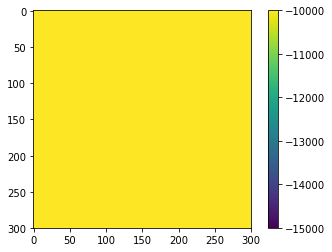

In [57]:
plt.imshow(stell_vel, vmin=-15000, vmax=-10000)
plt.colorbar()
plt.show()

In [ ]:
'''The output is the stellar velocity, so we will need to save a file
so that we can input it into kinemetry directly'''
'''Reuse the kinemetry input method from your earlier work with MaNGA'''

In [20]:
'''This is the type of ppxf that replicates the results for MaNGA'''
def ppxf_mileshc_nonvis(t,flux,noise,vr, plot, bs, conv, dg, mdg, regularization, redo_noise, last_chi,input_vel, input_sig, mom ):

    file_dir = '../ppxf'  # path of this procedure
    c=2.99792458e5
    input_z=np.exp( input_vel     /c)-1

 
    t=np.array(t)
    flux=np.array(flux)
    noise=np.array(noise)
        
        
    
    '''step 2: Mask with the other mask to restrict wavelengths'''
    mask_2 =  (t < 7409) & (t > 3540)
    
    flux=flux[mask_2]
    t=t[mask_2]
    noise=noise[mask_2]
   

    
    
    var_scaled = noise
    galaxy = flux   
    if regularization!=0:
        #TEMPLATES/=np.median(TEMPLATES))
        galaxy/=np.median(galaxy)
    #apparently we don't need the normalization
    #/np.median(flux)   # Normalize spectrum to avoid numerical issues

    
    loglam_gal = np.log(t)
    lam_gal = t
    
    #lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

    
    if redo_noise == 0:
        noise = var_scaled
    else:
        noise = var_scaled*np.sqrt(last_chi)

    c = 299792.458                  # speed of light in km/s
    frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel

    dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
  
    xs=np.linspace(0,len(lam_gal)-1,len(lam_gal))
    fwhm_gal = [(2.355*(lam_gal[x]))/2000 for x in xs] # Resolution FWHM of every pixel, in Angstroms
    
    #resolution is 2000
    #
    
    x_1=np.linspace(0,len(lam_gal)-2,len(lam_gal)-1)
    fwhm_gal=[2.355*(lam_gal[x+1]-lam_gal[x]) for x in x_1]
    fwhm_gal.append(fwhm_gal[len(x_1)-1])
    fwhm_gal=np.array(fwhm_gal)
    
    
    velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel
    
    
    #file_dir = glob.glob('../ppxf/miles_models/Mun*.fits')
    file_dir = glob.glob('../ppxf/indo_us/IRAF/*.fits')
    #file_dir = glob.glob('../MaNGA_code/practice_logcube/DAP/data/spectral_templates/miles_cluster/*.fits')

    

    hdu = fits.open(file_dir[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew_1 = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
    
    
    lam_gal_plot = lam_gal/(1+input_z)
    
    
    templates = np.empty((sspNew_1.size, len(file_dir)))
    
    fwhm_tem = 2.5

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)
    
    
    #print('fwhm_gal', fwhm_gal)
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(file_dir):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        '''if j==0 and plot=='yes':
            plt.plot(lam_temp, ssp, label='Pre Convolved')'''
        if conv=='yes':
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
    
   
    
    c = 299792.458
    dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
    
    #z=0
    '''goodpix also have to be adjusted for the redshift'''
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, input_z)
    
    vel = c*np.log(1 + input_z)   # Initial estimate of the galaxy velocity in km/s
    
    start = [vel, input_sig]  # (km/s), starting guess for [V, sigma]
    #start = [0,200]
    t = clock()
    if regularization !=0:
        templates/=np.median(templates)

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, bias=bs, plot=True, moments=mom,
              degree=dg,mdegree=mdg, vsyst=dv, velscale_ratio=vr, regul=regularization,
              clean=False)#was degree=12
    print('pp.sol', pp.sol)
    plt.clf()
    return lam_gal, galaxy, pp.sol[0], pp.sol[1],pp.error[0], pp.chi2
#pp.sol is vel and sig




In [ ]:
'''This is the type of ppxf that replicates the results for MaNGA'''
def ppxf_mileshc(t,flux,noise,vr, plot, bs, conv, dg, mdg, regularization, redo_noise, last_chi,input_vel, input_sig, mom ):

    file_dir = '../ppxf'  # path of this procedure
    c=2.99792458e5
    input_z=np.exp( input_vel     /c)-1

 
    t=np.array(t)
    flux=np.array(flux)
    noise=np.array(noise)
        
        
    
    '''step 2: Mask with the other mask to restrict wavelengths'''
    mask_2 =  (t < 7409) & (t > 3540)
    
    flux=flux[mask_2]
    t=t[mask_2]
    noise=noise[mask_2]
   

    
    
    var_scaled = noise
    
    if plot=='yes':
        fig=plt.figure()
        ax1=fig.add_subplot(2,1,1)
        ax1.plot(var_scaled, label='Noise')
        plt.legend()
        ax2=fig.add_subplot(2,1,2)
        ax2.plot(flux, label='flux')
        plt.legend()
        plt.show()
    galaxy = flux   
    if regularization!=0:
        #TEMPLATES/=np.median(TEMPLATES))
        galaxy/=np.median(galaxy)
    #apparently we don't need the normalization
    #/np.median(flux)   # Normalize spectrum to avoid numerical issues

    
    loglam_gal = np.log(t)
    lam_gal = t
    
    #lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

    if plot=='yes':
        plt.plot(lam_gal, galaxy, label='Air')
        
        plt.legend()
        plt.show()
    
    
    if redo_noise == 0:
        noise = var_scaled
    else:
        noise = var_scaled*np.sqrt(last_chi)

    c = 299792.458                  # speed of light in km/s
    frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
    
    print('frac', frac, lam_gal[1], lam_gal[0])
    dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
    #wdisp = t['wdisp'][mask]        # Intrinsic dispersion of every pixel, in pixels units
    #print('wdisp',len(wdisp), 'lam_gal', len(lam_gal))
    print(type(lam_gal))
    xs=np.linspace(0,len(lam_gal)-1,len(lam_gal))
    fwhm_gal = [(2.355*(lam_gal[x]))/2000 for x in xs] # Resolution FWHM of every pixel, in Angstroms
    
    #resolution is 2000
    #
    
    x_1=np.linspace(0,len(lam_gal)-2,len(lam_gal)-1)
    fwhm_gal=[2.355*(lam_gal[x+1]-lam_gal[x]) for x in x_1]
    fwhm_gal.append(fwhm_gal[len(x_1)-1])
    fwhm_gal=np.array(fwhm_gal)
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.axhline(y=(lam_gal[-1]-lam_gal[0])/len(lam_gal))
        plt.annotate('Mean FWHM = '+str(round(2.355*((lam_gal[-1]-lam_gal[0])/len(lam_gal)),1)),xy=(0.7,0.9),xycoords='axes fraction')
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel
    print('velscale', velscale)
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
    #fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
 
    
    #file_dir = glob.glob('../ppxf/miles_models/Mun*.fits')
    file_dir = glob.glob('../ppxf/indo_us/IRAF/*.fits')
    #file_dir = glob.glob('../MaNGA_code/practice_logcube/DAP/data/spectral_templates/miles_cluster/*.fits')

    print(len(file_dir), shape(file_dir))

    hdu = fits.open(file_dir[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew_1 = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
    
    
    lam_gal_plot = lam_gal/(1+input_z)
    
    lines=['Ca II H and K', 'G band','Mg b', 'Na I Doublet']
    wavelength_limits=[[3900,4100],[4230,4270],[5100,5300],[5800,5950]]
    
    if plot=='yes':
        fig=plt.figure()
        plt.title('Template vs Data')
        ax1=fig.add_subplot(1,2,1)
        ax1.plot(lam_temp,ssp, label='Template')
        
        plt.legend()

        ax2=fig.add_subplot(1,2,2)
        ax2.plot(lam_gal_plot, galaxy, label='Data')
      

        plt.legend()
        plt.tight_layout()
        plt.show()
    
    if plot=='yes':
        for i in range(len(lines)):
            plt.clf()
            fig=plt.figure()
            plt.title(lines[i])
            ax1=fig.add_subplot(2,1,1)
            ax1.plot(lam_temp,ssp, label='Template')
            print('wavelength lims', wavelength_limits[i])
            plt.xlim(wavelength_limits[i])
            ax1.set_yticks([])
            ax1.set_ylabel([])
            ax1.yaxis.set_visible(False)
            
            plt.legend()

            ax2=fig.add_subplot(2,1,2)
            ax2.plot(lam_gal_plot, galaxy, label='Data')
            plt.xlim(wavelength_limits[i])
        
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.set_yticks([])
            ax2.set_ylabel([])
            
            ax2.set_xticks([])
            ax2.set_xlabel([])

            plt.legend()
            plt.tight_layout()
            plt.show()
    
    templates = np.empty((sspNew_1.size, len(file_dir)))
    
    fwhm_tem = 2.5

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)
    
    
    #print('fwhm_gal', fwhm_gal)
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(file_dir):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        '''if j==0 and plot=='yes':
            plt.plot(lam_temp, ssp, label='Pre Convolved')'''
        if conv=='yes':
            if j==0:
                print('len gal', len(lam_gal), 'len temp pre conv', len(ssp))
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        if plot=='yes':
            plt.plot(lam_temp,ssp, label='Convolved')
        
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
        if j==0:
            print('len gal', len(lam_gal), 'len temp post conv', len(sspNew))
        
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
    
   
    if plot=='yes':
        plt.title('Templates ')
        #plt.legend()
        plt.show()
        
        fig=plt.figure()
        ax1=fig.add_subplot(211)
        ax1.plot(lam_gal, galaxy, label='Gal')
        ax1.set_xlim([5850,5950])
        #ax1.set_ylim([0.5,2.0])
        ax2=fig.add_subplot(212)
        ax2.plot(lam_temp, ssp, label='Template')
        ax2.set_xlim([5850,5950])
        plt.legend()
        plt.show()
    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
    
    #z=0
    '''goodpix also have to be adjusted for the redshift'''
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, input_z)
    print('must improve chi2 by: ', np.sqrt(2*len(goodpixels)))

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + input_z)   # Initial estimate of the galaxy velocity in km/s
    print('input vel', vel)
    start = [vel, input_sig]  # (km/s), starting guess for [V, sigma]
    #start = [0,200]
    t = clock()
    if regularization !=0:
        templates/=np.median(templates)

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, bias=bs, plot=True, moments=mom,
              degree=dg,mdegree=mdg, vsyst=dv, velscale_ratio=vr, regul=regularization,
              clean=False)#was degree=12
    print(pp)
    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    
    #plt.plot(logcube[4].data,logcube[6].data[:,20,20],lw=1, label='Model')

    plt.legend()
    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
    plt.xlim([6275,6400])
    plt.ylim([0.8,1.5])
    plt.show()
    return lam_gal, galaxy, pp.error[0], pp.chi2




This is the code from MaNGA_J0749 and hopefully allows us to output to kinemetry


def kinemetry(plate, fiber):
    
    plt.clf()
    
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b_stellar=pyfits.open(path_spec)
    #print(b[0].header)


    '''Now time to download the stellar velocities and create images of them'''

    
    
    
    file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
    file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #print(b_stellar[0].header)
    data_stel_vel=b_stellar['STELLAR_VEL'].data-25.89#'STELLAR_VEL'
    data_stel_vel_ivar=b_stellar['STELLAR_VEL_IVAR'].data
    print(plate, shape(data_stel_vel))
    data_stel_sig=np.sqrt(b_stellar['STELLAR_SIGMA'].data**2-b_stellar['STELLAR_SIGMACORR'].data**2)
    data_stel_sig_ivar=b_stellar['STELLAR_SIGMA_IVAR'].data
    counter=1
    plt.clf()
    
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r'Stellar Velocity [km s$^{-1}$]', y=1.08)
    '''if cen_x[i] ==0 and cen_y[i]==0:
        print('doin nothing')
    else:
        ax.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')
    '''
    im=ax.imshow(data_stel_vel, vmin=-200, vmax=200)
    cbar=plt.colorbar(im)
    
    '''ax1 = fig.add_subplot(2, 2, 3)
    ax1.set_title(r'Stellar Velocity Error [km s$^{-1}$]', y=1.08)
    im1=ax1.imshow(1./np.sqrt(data_stel_vel_ivar), vmin=0, vmax=100)
    cbar=plt.colorbar(im1)
    
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title(r'Stellar Velocity Dispersion [km s$^{-1}$]', y=1.08)
    im2=ax2.imshow(data_stel_sig, vmin=0, vmax=500)
    cbar2=plt.colorbar(im2)
    
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.set_title(r'Stellar Velocity Dispersion Error [km s$^{-1}$]', y=1.08)
    im3=ax3.imshow(1./np.sqrt(data_stel_sig_ivar), vmin=0, vmax=100)
    cbar3=plt.colorbar(im3)'''
    
    plt.tight_layout()
    
    savefig('../MaNGA/sigma_vel/kinemetry-maps-post-kinemetry-'+plate+'-'+fiber+'.pdf')
    
    
    '''make another figure of the r band intensity which we use for the initial guess of the center'''
    plt.clf()
    #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b=pyfits.open(path_spec)
    #print(b[0].header)




    r_band=b['SPX_MFLUX'].data
    
    '''path_spec='MaNGA_J0749/manga-8141-1901-LOGCUBE-VOR10-GAU-MILESHC.fits'
    b=pyfits.open(path_spec)
    r_band=b[9].data'''
    
    plt.title(r'r-band Flux')
    im=plt.imshow(r_band, vmin=0, vmax=r_band.max())
    square_size=len(r_band)
    
    
    x = np.linspace(0, square_size-1, square_size)
    y = np.linspace(0, square_size-1, square_size)
    x, y = np.meshgrid(x, y)
    
    initial_guess = (max(r_band.flatten()),square_size/2,square_size/2,1,1,0,0)
    
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), r_band.ravel(), p0=initial_guess)
    
    
    data_fitted = twoD_Gaussian((x, y), *popt)
    
    
    
    plt.contour(x, y, data_fitted.reshape(square_size, square_size), 10, colors='w', lw=2)
    #plt.colorbar(im)
    plt.annotate(r'x$_\mathrm{cen}$ = '+str(int(round(popt[1],0)))+' $\pm$ '+str(round(np.sqrt(pcov[1][1]),2)), xy=(0.03,0.90), xycoords='axes fraction', color='white', size=15)
    plt.annotate(r'y$_\mathrm{cen}$ = '+str(int(round(popt[2],0)))+' $\pm$ '+str(round(np.sqrt(pcov[2][2]),2)), xy=(0.03,0.80), xycoords='axes fraction', color='white', size=15)
    plt.annotate(str(plate)+' '+str(fiber), xy=(0.03, 0.70), xycoords='axes fraction', color='white', size=15)
    
    
    plt.colorbar(im)
    savefig('../MaNGA/sigma_vel/kinemetry-center-guess-'+plate+'-'+fiber+'.pdf')
    
    plt.clf()
    velocity_input=np.zeros((shape(data_stel_vel)[0],shape(data_stel_vel)[0]))
    for j in range(shape(data_stel_vel)[0]):
        for k in range(shape(data_stel_vel)[0]):
            vel=data_stel_vel[j][k]
            vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
            sig=data_stel_sig[j][k]
            sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
            if vel < -500:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                velocity_input[j][k]=0
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
                file.write(str(counter)+'\t'+str(0.5*(j-shape(data_stel_vel)[0]/2))+'\t'+str(0.5*(k-shape(data_stel_vel)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1
                velocity_input[j][k]=vel
    plt.clf()
    print('counter', counter)
    plt.imshow(velocity_input, vmin=-100, vmax=100)
    plt.colorbar()
    plt.show()
    file.close()
    
    
    
def kinemetry_gas(plate, fiber):
    
    plt.clf()
    
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b=pyfits.open(path_spec)
    #print(b[0].header)

    
    '''Now time to download the stellar velocities and create images of them'''

    
    
    
    file = open("../MaNGA/kinemetry_input_oiii_"+plate+'-'+fiber+".txt","w")
    file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #print(b_stellar[0].header)
    elines_vel=b['EMLINE_GVEL'].data
    elines_vel_ivar=b['EMLINE_GVEL_IVAR'].data
    elines_sig=np.sqrt(b['EMLINE_GSIGMA'].data**2-b['EMLINE_INSTSIGMA'].data**2)
    elines_sig_ivar=b['EMLINE_GSIGMA_IVAR'].data
    
    oiii_elines=elines_vel[3]
    elines_vel_ivar=elines_vel_ivar[3]
    elines_sig=elines_sig[3]
    elines_sig_ivar=elines_sig_ivar[3]
    
    counter=1
    plt.clf()
    
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r'[OIII] Velocity [km s$^{-1}$]', y=1.08)
    '''if cen_x[i] ==0 and cen_y[i]==0:
        print('doin nothing')
    else:
        ax.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')
    '''
    im=ax.imshow(oiii_elines, vmin=-200, vmax=200)
    cbar=plt.colorbar(im)
    
    
    
    plt.tight_layout()
    
    savefig('../MaNGA/sigma_vel/kinemetry-maps-pre-kinemetry-oiii-'+plate+'-'+fiber+'.pdf')
    
    
    
    plt.clf()
    velocity_input=np.zeros((shape(oiii_elines)[0],shape(oiii_elines)[0]))
    for j in range(shape(oiii_elines)[0]):
        for k in range(shape(oiii_elines)[0]):
            vel=oiii_elines[j][k]
            vel_e=np.sqrt(1./elines_vel_ivar[j][k])
            sig=elines_sig[j][k]
            sig_e=np.sqrt(1./elines_sig_ivar[j][k])
            if vel < -500:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                velocity_input[j][k]=0
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
                file.write(str(counter)+'\t'+str(0.5*(j-shape(oiii_elines)[0]/2))+'\t'+str(0.5*(k-shape(oiii_elines)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1
                velocity_input[j][k]=vel
    plt.clf()
    print('counter', counter)
    plt.imshow(velocity_input, vmin=-100, vmax=100)
    plt.colorbar()
    plt.show()
    file.close()

In [147]:
from ppxf import ppxf
import ppxf_util as util

SIMPLE  =                    T                                                  BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                 3848                                                  NAXIS2  =                    5                                                  EXTEND  =                    T /                                                TAI     =        4653266582.81 / 1st row Number of seconds since Nov 17 1858    RA      =            207.52136 / 1st row RA of telescope boresight (deg)        DEC     =            13.876127 / 1st row Dec of telescope boresight (degrees)   EQUINOX =              2000.00 /                                                RADECSYS= 'FK5     '           /                                                AZ      =        127.856238667 / 1st row Azimuth (encoder) of tele (0=N?) (deg) ALT     =        70.4200176667 / 1st row

NameError: name 'util' is not defined

In [ ]:
'''Testing paws dataset'''

import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.ndimage import iterate_structure

#for some reason I had to reshape. Numpy ignored the shape header.
'''paws_data = np.loadtxt("paws.txt").reshape(4,11,14)

#getting a list of images
paws = [p.squeeze() for p in np.vsplit(paws_data,4)]
'''

def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    struct = generate_binary_structure(2,2)

    neighborhood = iterate_structure(struct, 2).astype(bool)
    
    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    alt_local_max=maximum_filter(image,5)==image
    
    
    plt.clf()
    plt.imshow(alt_local_max)
    plt.title('Alt local Max')
    plt.show()
    
    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


#applying the detection and plotting results
'''for i, paw in enumerate(paws):
    detected_peaks = detect_peaks(paw)
    pp.subplot(4,2,(2*i+1))
    pp.imshow(paw)
    pp.subplot(4,2,(2*i+2) )
    pp.imshow(detected_peaks)

pp.show()'''
pp.imshow(result)
pp.show()

pp.imshow(detect_peaks(result))
pp.show()

print(generate_binary_structure(2,10))

In [90]:
demo_low_pass = np.zeros((3,3))
demo_low_pass[0,0] = 2
demo_low_pass[0,1] = 1
demo_low_pass[0,2] = 1
demo_low_pass[1,0] = 1
demo_low_pass[1,1] = 2
demo_low_pass[1,2] = 1
demo_low_pass[2,0] = 1
demo_low_pass[2,1] = 1
demo_low_pass[2,2] = 2
print(demo_low_pass)

[[ 2.  1.  1.]
 [ 1.  2.  1.]
 [ 1.  1.  2.]]


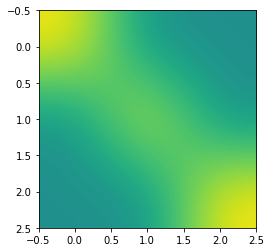

In [92]:
plt.imshow(demo_low_pass, vmax=2, vmin=0, interpolation='bicubic')
plt.show()

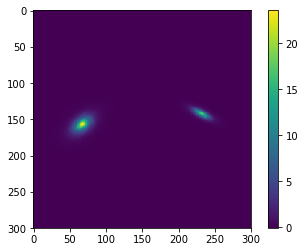

/Users/beckynevin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


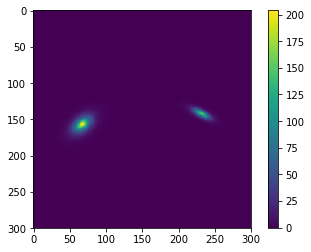

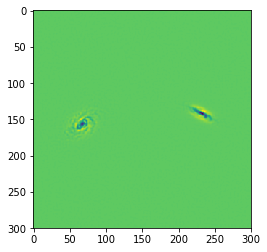

In [17]:

plt.imshow(result)
plt.colorbar()
plt.show()
kernel = np.array([[1, 1, 1],
               [1,  -8, 1],
               [1, 1, 1]])

kernel = np.ones((3,3))

lp_3 = ndimage.convolve(result, kernel)
plt.imshow(lp_3, label='3x3 Lowpass')
plt.legend()
plt.colorbar()
plt.show()

# A slightly "wider" lowpass filter 
kernel = np.array([[1, 1, 1, 1, 1],
               [1,  -1,  -2,  -1, 1],
               [1,  -2,  -4,  -2, 1],
               [1,  -1,  -2,  -1, 1],
               [1, 1, 1, 1, 1]])
lp_5 = ndimage.convolve(result, kernel)
plt.imshow(lp_5, label='5x5 Lowpass')
plt.legend()
plt.show()

In [ ]:
'''1. Create a 2d low pass filter. (reduces noise)
    1. Mean of area
    2. Gausian
    3. Fabuis (or any bump function)
2. Create a threshold for minimum local maximum (MLM) brightness. (to reject CRPs)
3. Find pixels that are both brighter than all 8 neighbors and greater than the MLM. 
4. ????
5. Profit $$$'''




In [18]:
'''this is the version for my data'''
import scipy.optimize as opt

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
#You'll obviously need to reshape the output for plotting, e.g:

def twoD_two_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset,
                     amplitude_2, xo_2, yo_2, sigma_x_2, sigma_y_2, theta_2):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)   
    xo_2 = float(xo_2)
    yo_2 = float(yo_2)  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    a_2 = (np.cos(theta_2)**2)/(2*sigma_x_2**2) + (np.sin(theta_2)**2)/(2*sigma_y_2**2)
    b_2 = -(np.sin(2*theta_2))/(4*sigma_x_2**2) + (np.sin(2*theta_2))/(4*sigma_y_2**2)
    c_2 = (np.sin(theta_2)**2)/(2*sigma_x_2**2) + (np.cos(theta_2)**2)/(2*sigma_y_2**2)
    
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))+ amplitude_2*np.exp( - (a_2*((x-xo_2)**2) + 2*b_2*(x-xo_2)*(y-yo_2) 
                            + c_2*((y-yo_2)**2)))
    return g.ravel()

In [19]:
import scipy.optimize as opt

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
#You'll obviously need to reshape the output for plotting, e.g:

# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 0, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201))
plt.colorbar()
#Do the fitting as before:

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)


popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)
#And plot the results:

data_fitted = twoD_Gaussian((x, y), *popt)

print(shape(data_noisy))
print(shape(data_fitted))

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
plt.show()


NameError: name 'np' is not defined